# GLMsingle: single-trial estimation in rapid event-related design

This notebook is my attempt at applying the new GLMsingle toolbox to the SVD dataset. I am starting with the tutorial provided on the GLMsingle GitHub and modifying it for the SVD dataset. (LM)
https://htmlpreview.github.io/?https://github.com/kendrickkay/GLMsingle/blob/main/examples/example1.html   

By default, the tool implements a set of optimizations that improve upon generic GLM approaches by: (1) identifying an optimal hemodynamic response function (HRF) at each voxel, (2) deriving a set of useful GLM nuisance regressors via "GLMdenoise" and picking an optimal number to include in the final GLM, and (3) applying a custom amount of ridge regularization at each voxel using an efficient technique called "fracridge". The output of GLMsingle are GLM betas reflecting the estimated percent signal change in each voxel in response to each experimental stimulus or condition being modeled.

Example 1 contains a full walkthrough of the process of loading an example dataset and design matrix, estimating neural responses using GLMsingle, estimating the reliability of responses at each voxel, and comparing those achieved via GLMsingle to those achieved using a baseline GLM. After loading and visualizing formatted fMRI time-series and their corresponding design matrices, we will describe the default behavior of GLMsingle and show how to modify hyperparameters if the user desires. Throughout the notebook we will highlight important metrics and outputs using figures, print statements, and comments.

## A note about conda environments

When running this notebook, make sure you have activated the mindeye conda environment.

## Define settings

What subject and session do you want to run? 

In [2]:
sub = 'sub-001'
session = 'ses-03'
multi_session = True
if multi_session:
    ses_list = ["ses-02", "ses-03"]
task='study'

if sub=='sub-002':
    n_runs=9
else:
    n_runs=16

##### Do you want to intersect brain masks from each run to create an average mask? If avg_mask already exists, set this to 0.

In [15]:
make_avg_mask = 0

Do you want to load the raw 4D data and run the time-intensive NiftiMasker? 
If the 2D data already exist, set this to 0.

In [4]:
load_epi = 1


##### Do you need to upsample the fMRI data? If the upsampled data already exists, set this to 0.

In [5]:
run_upsampling = 1

Do you want to export design matrix to csv? 

In [6]:
export_csv = 1

Do you want to run GLMsingle? If you want to load existing GLMsingle outputs, set this to 0.

In [7]:
run_glmsingle = 1
run_glmbaseline = 1

Do you want to run reliability calculations?

In [8]:
run_reliability = 1

## Import necessary packages

In [9]:
import numpy as np
import pandas as pd
import nibabel as nib
from nibabel import imagestats
import nilearn
from nilearn.input_data import NiftiMasker
from nilearn.masking import intersect_masks
from nilearn import image
from nilearn.plotting import plot_roi
from nilearn.plotting import plot_anat
from nilearn.plotting import plot_epi
import scipy
import scipy.stats as stats
import scipy.io as sio
import matplotlib.pyplot as plt

import os
from os.path import join, exists, split
import sys
import time
import urllib.request
import copy
import warnings
from tqdm import tqdm
from pprint import pprint
warnings.filterwarnings('ignore')
import h5py

!pip install git+https://github.com/cvnlab/GLMsingle.git
import glmsingle
from glmsingle.glmsingle import GLM_single

# %matplotlib inline 
# %autosave 5
#sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})

  Cloning https://github.com/cvnlab/GLMsingle.git to /tmp/pip-req-build-mfx7jjdj
  Running command git clone --filter=blob:none --quiet https://github.com/cvnlab/GLMsingle.git /tmp/pip-req-build-mfx7jjdj
  Resolved https://github.com/cvnlab/GLMsingle.git to commit c96337cf8b172cc7608df0782b8bdb84f930e5b9
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Set paths and load settings

In [10]:
example = 0
stimdur = 3
if session == "ses-01":
    tr_orig = 2.0
else:
    tr_orig = 1.8
tr = 1 # after upsampling
n_trs = 281

In [11]:
# bids directory
homedir = '/jukebox/norman/rsiyer/rtmindeye/data_correct/bids'

# datadir is fmriprep folder for this subject, outputdir is glmsingle derivatives
datadir = join(homedir,'derivatives','fmriprep',sub)
maskdir = join(homedir,'derivatives','masks', sub)
designdir = join(homedir, '../design/')
outputdir = join(homedir,'derivatives','glmsingle/')
func_dir = join(datadir,f'{session}','func/')
defaced_dir = join(homedir,'derivatives','deface/')
loaddir = join(homedir,'derivatives','glmsingle',sub)

# make a directory for this subject
path = os.path.join(outputdir,sub)
os.makedirs(path,exist_ok=True)
os.makedirs(maskdir,exist_ok=True)

print(f'directory to load preprocessed data from:\n\t{datadir}\n')
print(f'directory to save outputs:\n\t{path}\n')

directory to load preprocessed data from:
	/jukebox/norman/rsiyer/rtmindeye/data_correct/bids/derivatives/fmriprep/sub-001

directory to save outputs:
	/jukebox/norman/rsiyer/rtmindeye/data_correct/bids/derivatives/glmsingle/sub-001



I ran into an issue because of my small voxels, I have more than 1,000,000 "voxels" in my brain images (including voxels outside the brain).

I'm going to use NiftiMasker to apply the average brain mask to data, then instead of passing 4D (XYZT) images to data array, pass 2D (units x time) to data array.

## Load this subject's design matrix
design is in the format design[run] rows are timepoints, columns are distinct images

In [12]:
if (sub=='sub-001' and session=='ses-01') or (sub=='sub-002' and session=='ses-01'):
    filename = f"{designdir}csv/{sub}_{session}.csv"
    data = pd.read_csv(filename)
    images = data['current_image'].values[23:]
    starts = data['trial.started'].values[23:]
    is_new_run = data['is_new_run'].values[23:]
else: 
    filename = f"{designdir}csv/{sub}_{session}.csv"
    data = pd.read_csv(filename)
    starts = data['trial.started'].values[14:]
    images = data['current_image'].values[14:][~np.isnan(starts)]
    is_new_run = data['is_new_run'].values[14:][~np.isnan(starts)]
    starts = starts[~np.isnan(starts)]
print(filename)

unique_images = np.unique(images.astype(str))
len_unique_images = len(unique_images)
print("len_unique_images",len_unique_images)
print("n_runs",n_runs)

print(images[:4])
print(starts[:4])
print(is_new_run[:4])

# assert len(images[images!="blank.jpg"]) == 1008
# assert len(np.unique(images[images!="blank.jpg"])) == 708

/jukebox/norman/rsiyer/rtmindeye/data_correct/bids/../design/csv/sub-001_ses-02.csv
len_unique_images 709
n_runs 16
['all_stimuli/special515/special_40840.jpg'
 'all_stimuli/unchosen_nsd_1000_images/unchosen_5137_cocoid_57944.png'
 'all_stimuli/shared1000_notspecial/notspecial_38278.png'
 'all_stimuli/special515/special_30632.jpg']
[658.05201488 662.06546921 666.06833092 670.06900812]
[0. 0. 0. 0.]


In [13]:
design = [np.zeros((n_trs, len_unique_images)) for _ in range(n_runs)]
starting_time = starts[0]
cur_run = 0
first_trial_of_new_run = False
print(f"run = {cur_run}")
for i in range(len(images)):        
    if first_trial_of_new_run: # is the first trial of a new run?
        starting_time = starts[i]
        cur_run += 1
        print(f"run = {cur_run}")
        first_trial_of_new_run = False
        
    if is_new_run[i] == 1: # is this the last trial of the run?
        first_trial_of_new_run = True
    
    if images[i] == "blank.jpg":
        continue

    image_idx = np.where(images[i]==unique_images)[0].item()
    timepoint = int(np.round(starts[i] - starting_time))
    design[cur_run][timepoint, image_idx] = 1

run = 0
run = 1
run = 2
run = 3
run = 4
run = 5
run = 6
run = 7
run = 8
run = 9
run = 10
run = 11
run = 12
run = 13
run = 14
run = 15


Text(0, 0.5, 'time (TR)')

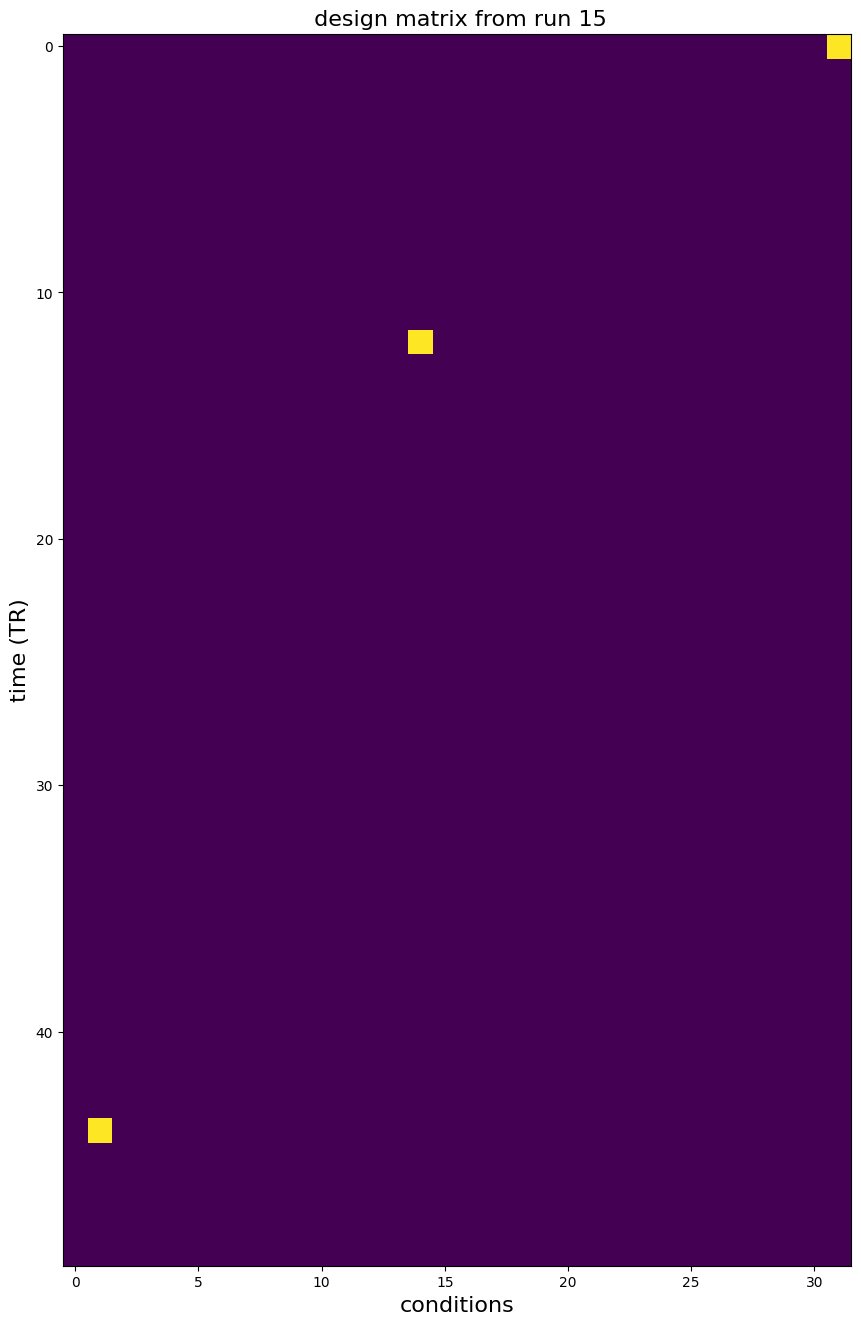

In [14]:
# Plot design matrix for each run
run=14
plt.figure(figsize=(16,16))
plt.imshow(design[run][:50,:32],interpolation='none')
plt.title(' design matrix from run %i' %(run+1), fontsize=16)
plt.xlabel('conditions',fontsize=16)
plt.ylabel('time (TR)',fontsize=16) 


## Create a brain mask that intersects each run's brain mask from fMRIPrep

From GLMSingle FAQ: The safest approach is to completely zero out the data for a voxel that does not have full data for all of the runs that you are analyzing with GLMsingle.

keeping mask for ses 1 run 1
keeping bold data for ses 1 run 1
keeping mask for ses 1 run 2
keeping bold data for ses 1 run 2
keeping mask for ses 1 run 3
keeping bold data for ses 1 run 3
keeping mask for ses 1 run 4
keeping bold data for ses 1 run 4
keeping mask for ses 1 run 5
keeping bold data for ses 1 run 5
keeping mask for ses 1 run 6
keeping bold data for ses 1 run 6
keeping mask for ses 1 run 7
keeping bold data for ses 1 run 7
keeping mask for ses 1 run 8
keeping bold data for ses 1 run 8
keeping mask for ses 1 run 9
keeping bold data for ses 1 run 9
keeping mask for ses 1 run 10
keeping bold data for ses 1 run 10
keeping mask for ses 1 run 11
keeping bold data for ses 1 run 11
keeping mask for ses 1 run 12
keeping bold data for ses 1 run 12
keeping mask for ses 1 run 13
keeping bold data for ses 1 run 13
keeping mask for ses 1 run 14
keeping bold data for ses 1 run 14
keeping mask for ses 1 run 15
keeping bold data for ses 1 run 15
keeping mask for ses 1 run 16
keeping bold 

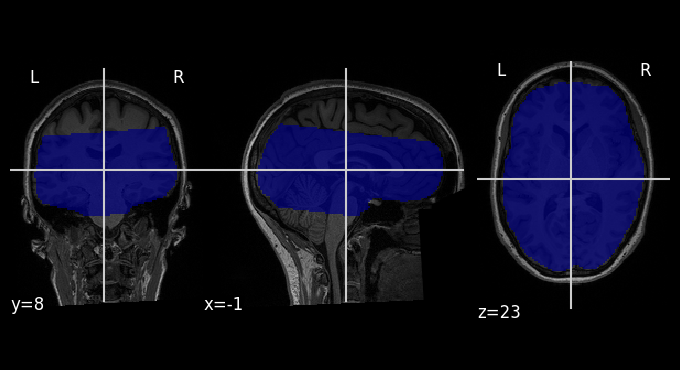

In [19]:
if make_avg_mask == 1:
    mask_imgs=[]
    mask_nsd, affine_nsd = nilearn.masking.load_mask_img(f'{maskdir}/sub-001_nsdgeneral.nii.gz')
    epi_imgs = []
    
    if multi_session:
        for ses in ses_list:
            for run in range(1,n_runs+1):
                if run < 10:
                    mask_name = f'{datadir}/{ses}/func/{sub}_{ses}_task-study_run-0{run}_space-T1w_desc-brain_mask.nii.gz'
                    epi_file = f'{datadir}/{ses}/func/{sub}_{ses}_task-study_run-0{run}_space-T1w_desc-preproc_bold.nii.gz'

                else:
                    mask_name = f'{datadir}/{ses}/func/{sub}_{ses}_task-study_run-{run}_space-T1w_desc-brain_mask.nii.gz'
                    epi_file = f'{datadir}/{ses}/func/{sub}_{ses}_task-study_run-{run}_space-T1w_desc-preproc_bold.nii.gz'

                mask_imgs.append(mask_name)
                epi_imgs.append(epi_file)
        
        # print(mask_imgs)
        func_masks = []
        epis = []
        # upsample ses-01 BOLD and func masks based on nsdgeneral
        for s, ses in enumerate(ses_list):
            for run in range(1, n_runs+1):
                idx = run + s*n_runs - 1
                curr_mask = nilearn.image.load_img(mask_imgs[idx])
                curr_epi = nilearn.image.load_img(epi_imgs[idx])
                
                if not np.all(curr_mask.affine == affine_nsd):
                    print(f'resampling mask for ses {s+1} run {run}')
                    func_masks.append(nilearn.image.resample_img(curr_mask, target_affine=affine_nsd, target_shape=mask_nsd.shape))
                    if run < 10:
                        mask_name = f'{datadir}/{ses}/func/{sub}_{ses}_task-study_run-0{run}_space-T1w_desc-brain_mask.nii.gz'
                    else:
                        mask_name = f'{datadir}/{ses}/func/{sub}_{ses}_task-study_run-{run}_space-T1w_desc-brain_mask.nii.gz'
                    # nib.save(func_masks[-1], mask_name)
                    print(f"saved resampled func mask to {mask_name}")
                    
                else:
                    print(f'keeping mask for ses {s+1} run {run}')
                    func_masks.append(curr_mask)
        
                if not np.all(curr_epi.affine == affine_nsd):
                    print(f'resampling bold data for ses {s+1} run {run}')
                    epis.append(nilearn.image.resample_img(curr_epi, target_affine=affine_nsd, target_shape=mask_nsd.shape))
                    if run < 10:
                        epi_file = f'{datadir}/{ses}/func/{sub}_{ses}_task-study_run-0{run}_space-T1w_desc-preproc_bold.nii.gz'
                    else:
                        epi_file = f'{datadir}/{ses}/func/{sub}_{ses}_task-study_run-{run}_space-T1w_desc-preproc_bold.nii.gz'
                    # nib.save(epis[-1], epi_file)
                    print(f"saved resampled bold run to {epi_file}")
        
                else:
                    print(f'keeping bold data for ses {s+1} run {run}')
                    epis.append(curr_epi)
    
        assert np.all([np.all(func_masks[i].affine == affine_nsd) for i in range(len(func_masks))]) # nsdgeneral roi is same resolution as all others
        assert np.all([np.all(epis[i].affine == affine_nsd) for i in range(len(epis))]) # nsdgeneral roi is same resolution as all others

        avg_mask=intersect_masks(func_masks, threshold=0.5, connected=True)


    elif not multi_session:
        for run in range(1,n_runs+1):
            if run < 10:
                mask_name = func_dir + sub + '_%s_task-study_run-0%i_space-T1w_desc-brain_mask.nii.gz' % (session, run)
            else:
                mask_name = func_dir + sub + '_%s_task-study_run-%i_space-T1w_desc-brain_mask.nii.gz' % (session, run)
            mask_imgs.append(mask_name)    
    
        # intersect all session 1 brain masks    
        avg_mask=intersect_masks(mask_imgs, threshold=0.5, connected=True)

    # Save the mask
    dimsize=avg_mask.header.get_zooms()
    affine_mat = avg_mask.affine
    hdr = avg_mask.header  # get a handle for the .nii file's header
    hdr.set_zooms((dimsize[0], dimsize[1], dimsize[2]))
    output_name = maskdir + '/%s_brain_multi.nii.gz' % (sub)
    print('Save average mask:', output_name)
    nib.save(avg_mask, output_name)
    print('')
    
elif make_avg_mask == 0:
    #Load brain mask
    file_in = maskdir + '/%s_brain_multi.nii.gz' % (sub)
    print('Loading average brain mask:', file_in)
    print('')
    avg_mask=nib.load(file_in)

# plot
t1_file = defaced_dir + sub + '_%s_T1w_defaced.nii.gz' %session
t1_img = image.load_img(t1_file)
plot_roi(avg_mask, bg_img=t1_img)

# mask info
dimsize=avg_mask.header.get_zooms()
affine_mat = avg_mask.affine
brain=avg_mask.get_fdata()
xyz=brain.shape #xyz dimensionality of brain mask and epi data

print('Mask dimensions:', dimsize)
print('')
print('Affine:')
print(affine_mat)
print('')
print(f'There are {np.sum(brain)} voxels in the included brain mask\n')

## Apply mask to each run of functional data
Data will go from 4D (x,y,z,t) to 2D

In [24]:
# uncomment to verify that all functional masks and BOLD runs have the same affine transform as our subject_nsdgeneral mask - should already be taken care of above if make_avg_mask == 1

# mask_imgs=[]
# mask_nsd, affine_nsd = nilearn.masking.load_mask_img(f'{maskdir}/sub-001_nsdgeneral.nii.gz')
# epi_imgs = []

# for ses in ses_list:
#     for run in tqdm(range(1,n_runs+1)):
#         if run < 10:
#             mask_name = f'{datadir}/{ses}/func/{sub}_{ses}_task-study_run-0{run}_space-T1w_desc-brain_mask.nii.gz'
#             epi_file = f'{datadir}/{ses}/func/{sub}_{ses}_task-study_run-0{run}_space-T1w_desc-preproc_bold.nii.gz'

#         else:
#             mask_name = f'{datadir}/{ses}/func/{sub}_{ses}_task-study_run-{run}_space-T1w_desc-brain_mask.nii.gz'
#             epi_file = f'{datadir}/{ses}/func/{sub}_{ses}_task-study_run-{run}_space-T1w_desc-preproc_bold.nii.gz'

#         mask_imgs.append(mask_name)
#         epi_imgs.append(epi_file)


# func_masks = []
# epis = []

# for s, ses in enumerate(ses_list):
#     for run in tqdm(range(1, n_runs+1)):
#         idx = run + s*n_runs - 1
#         curr_mask = nilearn.image.load_img(mask_imgs[idx])
#         curr_epi = nilearn.image.load_img(epi_imgs[idx])
#         func_masks.append(curr_mask)
#         epis.append(curr_epi)

# assert np.all([np.all(func_masks[i].affine == affine_nsd) for i in range(len(func_masks))]) # nsdgeneral roi is same resolution as all others
# assert np.all([np.all(epis[i].affine == affine_nsd) for i in range(len(epis))]) # nsdgeneral roi is same resolution as all others

100%|████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:45<00:00,  2.87s/it]


In [20]:
# get some info about epi data by loading study run 1
epi_file=f"{datadir}/{session}/func/{sub}_{session}_task-study_run-01_space-T1w_desc-preproc_bold.nii.gz"
epi_data=nib.load(epi_file)
run1=epi_data.get_fdata()


print('checking epi data for run 1:', epi_file)
print('')
epi_dimsize=epi_data.header.get_zooms()
epi_affine=epi_data.affine
print('Dimensions:', epi_dimsize)
print('Affine:')
print(epi_data.affine)
print('')

# get shape of data volume (XYZ) for convenience
xyz = run1.shape[:3]
xyzt = run1.shape
print(xyz)
print(xyzt)

# double check that brain mask and epi data have same dimensions and affine
assert avg_mask.header.get_zooms() == epi_dimsize[:3]
assert avg_mask.affine.all() == epi_data.affine.all()

checking epi data for run 1: /jukebox/norman/rsiyer/rtmindeye/data_correct/bids/derivatives/fmriprep/sub-001/ses-02/func/sub-001_ses-02_task-study_run-01_space-T1w_desc-preproc_bold.nii.gz

Dimensions: (1.8, 1.8, 1.8, 1.8)
Affine:
[[  1.79999995   0.           0.         -71.30000305]
 [  0.           1.79999995   0.         -78.40000153]
 [  0.           0.           1.79999995 -47.80000305]
 [  0.           0.           0.           1.        ]]

(78, 102, 78)
(78, 102, 78, 156)


In [21]:
# variables that will contain bold time-series and design matrices from each run
data = []
TR_run = []

if load_epi == 1:
    epi_masker=NiftiMasker(mask_img=avg_mask)

    for run in range(0,n_runs):
        if run < 9:
            epi_file=datadir + '/%s/func/%s_%s_task-study_run-0%i_space-T1w_desc-preproc_bold.nii.gz' % (session,sub,session,run+1)
        else:
            epi_file=datadir + '/%s/func/%s_%s_task-study_run-%i_space-T1w_desc-preproc_bold.nii.gz' % (session,sub,session,run+1)
    
        print('loading data for run', run+1, ':', epi_file)
        #print(run,ses,task,rr)
        print('')
        epi_mask_data = epi_masker.fit_transform(epi_file)
    
        # alternate to NiftiMasker
        # from nilearn.masking import apply_mask
        # masked_data = apply_mask(epi_file, mask_img)
    
        epi_mask_data = epi_mask_data.T #transpose to make it voxels,time
        #print('epi data shape:', epi_mask_data.shape)

        # add this run's data to data variable
        data.append(epi_mask_data)
        TR_run.append(epi_mask_data.shape[1])
        print('BOLD data shape:', data[run].shape)
        print('TRs in this run:', TR_run[run])
        
        # save individual run data to npy file
        filename = os.path.join(outputdir, sub, '%s_%s_task-study_run-0%i_2D_bold' %(sub,session,run+1))
        print(f'\n*** Saving data to {filename} ***\n')
        np.save(filename, epi_mask_data)

elif load_epi == 0:
    for run in range(0,n_runs):        
        
        # load npy data file
        filename = os.path.join(outputdir, sub, '%s_%s_task-study_run-0%i_2D_bold.npy' %(sub,session,run+1))
        print(f'\n*** Loading data from {filename} ***\n')
        epi_mask_data = np.load(filename)
        
        # add this run's data to data variable
        data.append(epi_mask_data)
        TR_run.append(epi_mask_data.shape[1])
        
        print('BOLD data shape:', data[run].shape)
        print('TRs in this run:', TR_run[run])
        
print('')
print('number of runs in BOLD data:', len(data))  

loading data for run 1 : /jukebox/norman/rsiyer/rtmindeye/data_correct/bids/derivatives/fmriprep/sub-001/ses-02/func/sub-001_ses-02_task-study_run-01_space-T1w_desc-preproc_bold.nii.gz

BOLD data shape: (186947, 156)
TRs in this run: 156

*** Saving data to /jukebox/norman/rsiyer/rtmindeye/data_correct/bids/derivatives/glmsingle/sub-001/sub-001_ses-02_task-study_run-01_2D_bold ***

loading data for run 2 : /jukebox/norman/rsiyer/rtmindeye/data_correct/bids/derivatives/fmriprep/sub-001/ses-02/func/sub-001_ses-02_task-study_run-02_space-T1w_desc-preproc_bold.nii.gz

BOLD data shape: (186947, 156)
TRs in this run: 156

*** Saving data to /jukebox/norman/rsiyer/rtmindeye/data_correct/bids/derivatives/glmsingle/sub-001/sub-001_ses-02_task-study_run-02_2D_bold ***

loading data for run 3 : /jukebox/norman/rsiyer/rtmindeye/data_correct/bids/derivatives/fmriprep/sub-001/ses-02/func/sub-001_ses-02_task-study_run-03_space-T1w_desc-preproc_bold.nii.gz

BOLD data shape: (186947, 156)
TRs in this r

## Upsample fMRI data to 1-sec TR
At this point, we have extracted all brain voxels and flattened the data to 2D (voxels,TR). 
Now we will interpolate the time-series to go from 1.5 sec TR to 1 sec TR. 

In [22]:
from tseriesinterp import *

# import importlib
# import tseriesinterp #import the module here, so that it can be reloaded.
# importlib.reload(tseriesinterp)
# from tseriesinterp import * # or whatever name you want.

In [23]:
# Upsample one run as an example
data_upsampled = tseriesinterp(data[0], 1.8, 1, dim=1)
data_upsampled.shape

(186947, 281)

Text(0, 0.5, 'Voxel Intensity')

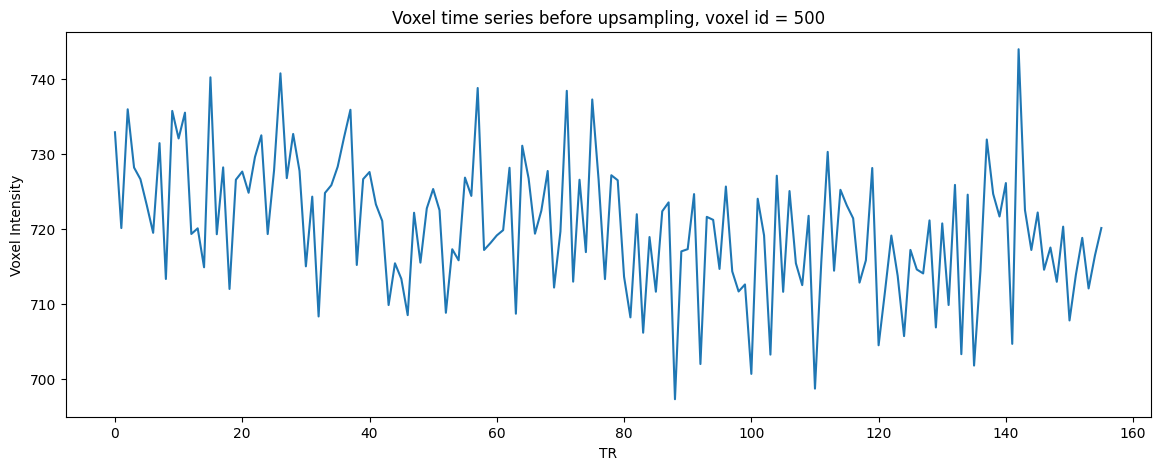

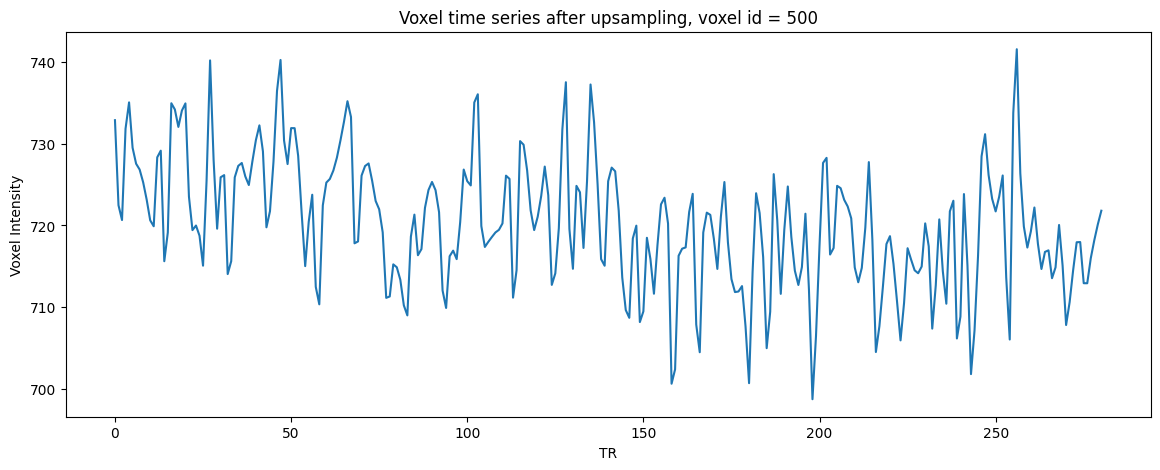

In [24]:
voxel_id=500

f, ax = plt.subplots(1,1, figsize=(14,5))
ax.plot(data[0][voxel_id, :])
ax.set_title('Voxel time series before upsampling, voxel id = %d' % voxel_id)
ax.set_xlabel('TR')
ax.set_ylabel('Voxel Intensity')

f, ax = plt.subplots(1,1, figsize=(14,5))
ax.plot(data_upsampled[voxel_id, :])
ax.set_title('Voxel time series after upsampling, voxel id = %d' % voxel_id)
ax.set_xlabel('TR')
ax.set_ylabel('Voxel Intensity')


In [25]:
data_upsampled = []
TR_run_upsampled = []

if run_upsampling == 1:
    
    for run in range(0,n_runs): 
        # perform interpolation
        data_new = tseriesinterp(data[run], tr_orig, tr, dim=1)
    
        # add this run's data to data variable
        data_upsampled.append(data_new)
        TR_run_upsampled.append(data_new.shape[1])
            
        print('BOLD data shape:', data_upsampled[run].shape)
        print('TRs in this run:', TR_run_upsampled[run])
    
        # save individual run data to npy file
        filename = os.path.join(outputdir, sub, '%s_%s_task-study_run-0%i_2D_upsampled_bold' %(sub,session,run+1))
        print(f'\n*** Saving data to {filename} ***\n')
        np.save(filename, data_new)

elif run_upsampling == 0:
    
    for run in range(0,n_runs):        
        # load npy data file
        filename = os.path.join(outputdir, sub, '%s_%s_task-study_run-0%i_2D_upsampled_bold.npy' %(sub,session,run+1))
        print(f'\n*** Loading data from {filename} ***\n')
        data_new = np.load(filename)
        
        # add this run's data to data variable
        data_upsampled.append(data_new)
        TR_run_upsampled.append(data_new.shape[1])
        
        print('BOLD data shape:', data_upsampled[run].shape)
        print('TRs in this run:', TR_run_upsampled[run])
            
print('')
print('number of runs in upsampled BOLD data:', len(data_upsampled))   

BOLD data shape: (186947, 281)
TRs in this run: 281

*** Saving data to /jukebox/norman/rsiyer/rtmindeye/data_correct/bids/derivatives/glmsingle/sub-001/sub-001_ses-02_task-study_run-01_2D_upsampled_bold ***

BOLD data shape: (186947, 281)
TRs in this run: 281

*** Saving data to /jukebox/norman/rsiyer/rtmindeye/data_correct/bids/derivatives/glmsingle/sub-001/sub-001_ses-02_task-study_run-02_2D_upsampled_bold ***

BOLD data shape: (186947, 281)
TRs in this run: 281

*** Saving data to /jukebox/norman/rsiyer/rtmindeye/data_correct/bids/derivatives/glmsingle/sub-001/sub-001_ses-02_task-study_run-03_2D_upsampled_bold ***

BOLD data shape: (186947, 281)
TRs in this run: 281

*** Saving data to /jukebox/norman/rsiyer/rtmindeye/data_correct/bids/derivatives/glmsingle/sub-001/sub-001_ses-02_task-study_run-04_2D_upsampled_bold ***

BOLD data shape: (186947, 281)
TRs in this run: 281

*** Saving data to /jukebox/norman/rsiyer/rtmindeye/data_correct/bids/derivatives/glmsingle/sub-001/sub-001_ses

In [26]:
# print some relevant metadata
print(f'There are {len(data_upsampled)} runs in total\n')
#print(f'N = {data[0].shape[1]} TRs per run\n')
print(f'XYZ dimensionality is: {xyz}\n')
print(f'The dimensions of the 2D data for each run are:\n {data_upsampled[0].shape}\n {data_upsampled[1].shape}\n {data_upsampled[2].shape}') 
print(f' {data_upsampled[3].shape}\n {data_upsampled[4].shape}\n {data_upsampled[5].shape}\n {data_upsampled[6].shape}\n {data_upsampled[7].shape}')
print(f'The stimulus duration is {stimdur} seconds\n')
print(f'The TR is {tr} seconds\n')
print(f'There are {np.sum(brain)} voxels in the included brain mask\n')
#print(f'There are {np.sum(roi)} voxels in the included visual ROI\n')
print(f'Numeric precision of data is: {type(data[0][0,0])}\n')


There are 16 runs in total

XYZ dimensionality is: (78, 102, 78)

The dimensions of the 2D data for each run are:
 (186947, 281)
 (186947, 281)
 (186947, 281)
 (186947, 281)
 (186947, 281)
 (186947, 281)
 (186947, 281)
 (186947, 281)
The stimulus duration is 3 seconds

The TR is 1 seconds

There are 186947.0 voxels in the included brain mask

Numeric precision of data is: <class 'numpy.float32'>



Text(0.5, 1.0, 'example slice from run 9')

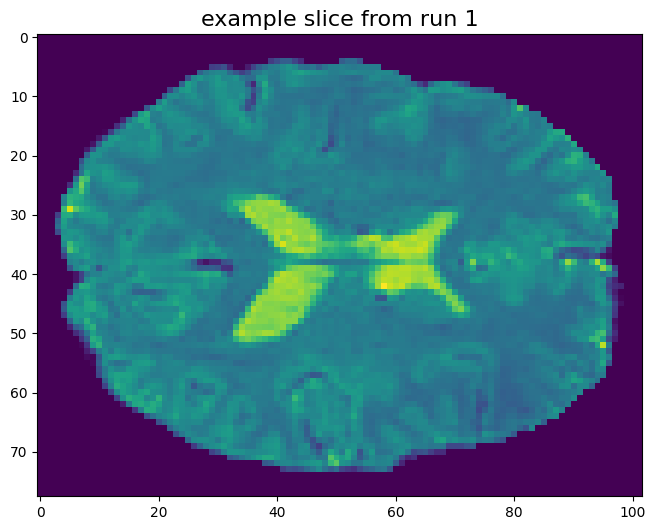

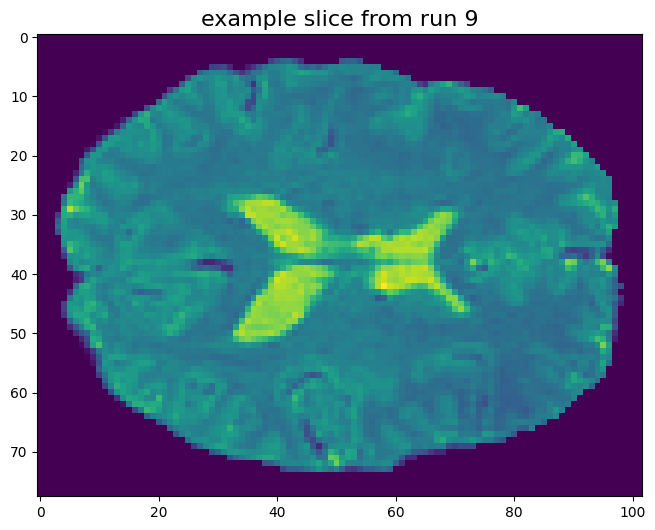

In [27]:
# plot example slice from run 1 and run 16
# first, we need to unmask the data to get it back into 3D/4D format:
X = nilearn.masking.unmask(data_upsampled[0].T, avg_mask)
run1 = X.get_fdata()

X = nilearn.masking.unmask(data_upsampled[15].T, avg_mask)
run16 = X.get_fdata()

z=45
plt.figure(figsize=(20,6))
plt.subplot(121)
plt.imshow(run1[:,:,z,0])
plt.title('example slice from run 1',fontsize=16)

plt.figure(figsize=(20,6))
plt.subplot(121)
plt.imshow(run16[:,:,z,0])
plt.title('example slice from run 9',fontsize=16)

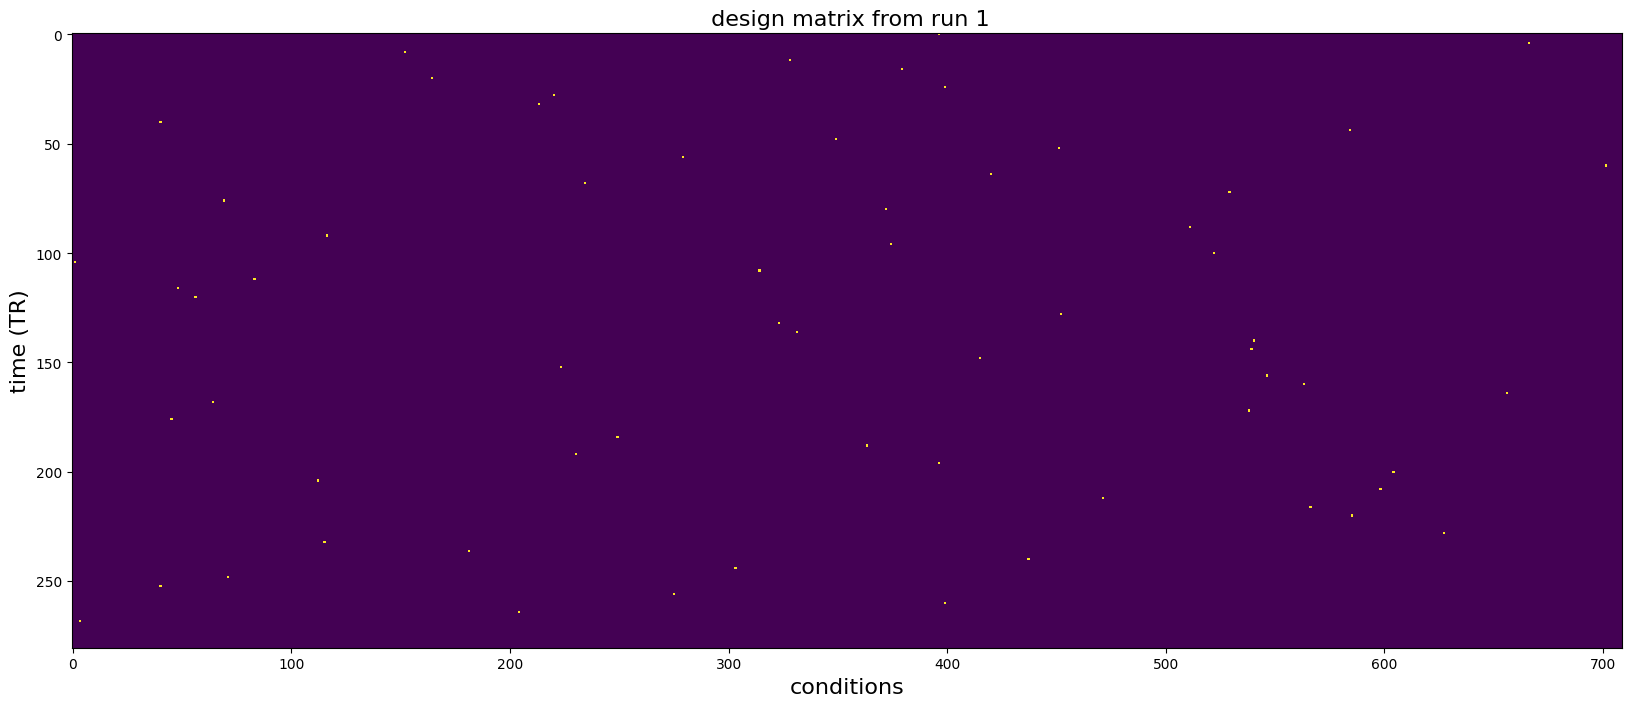

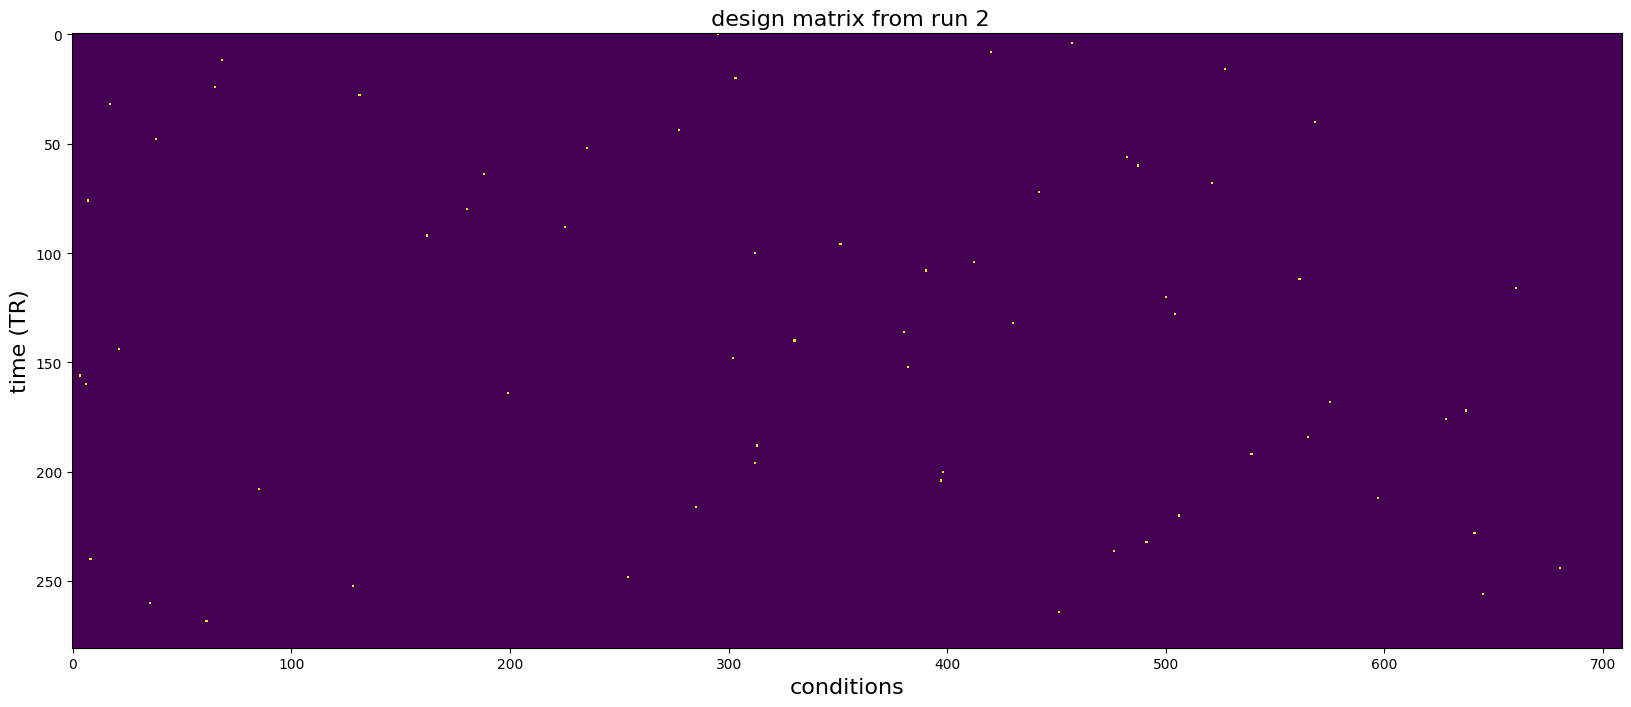

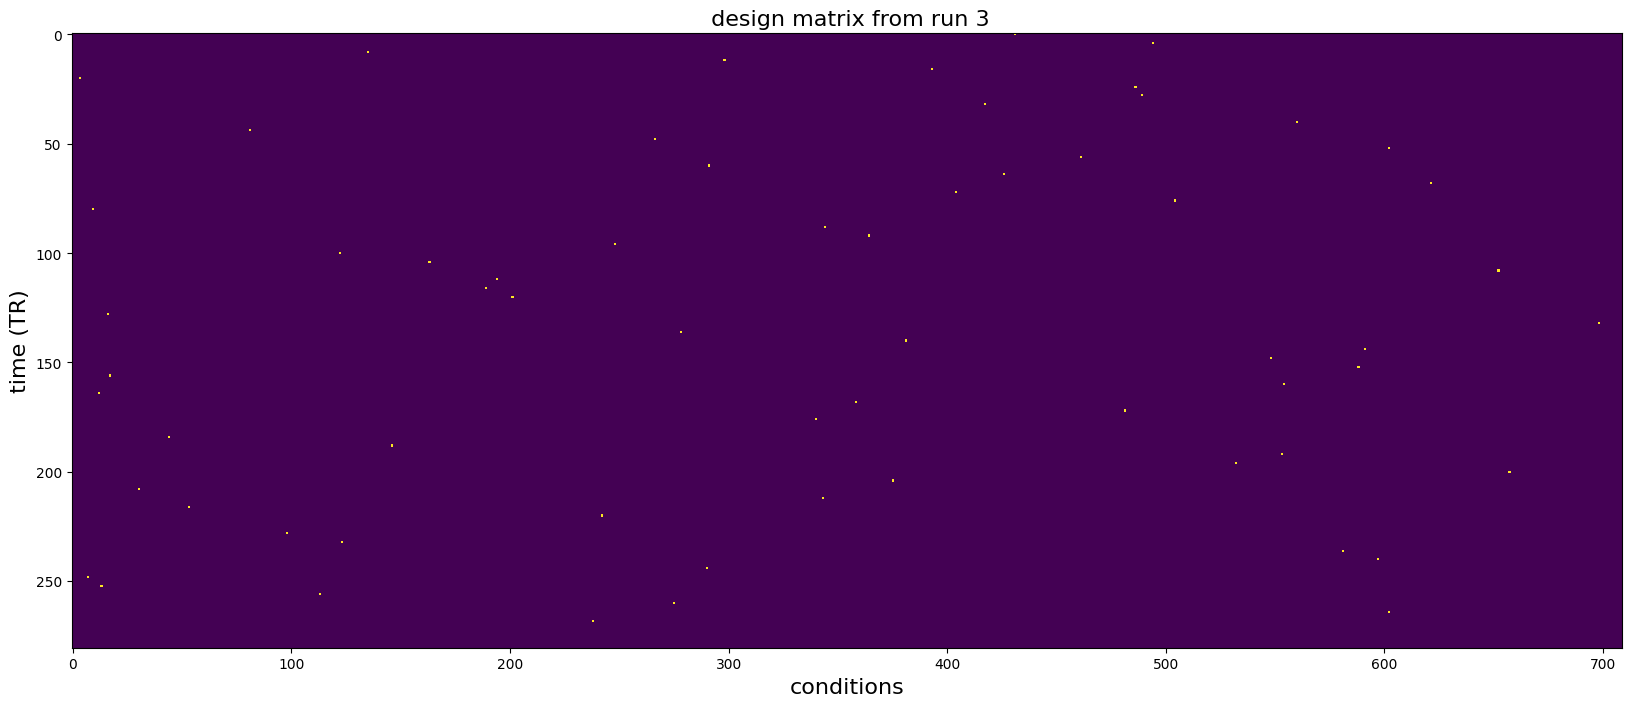

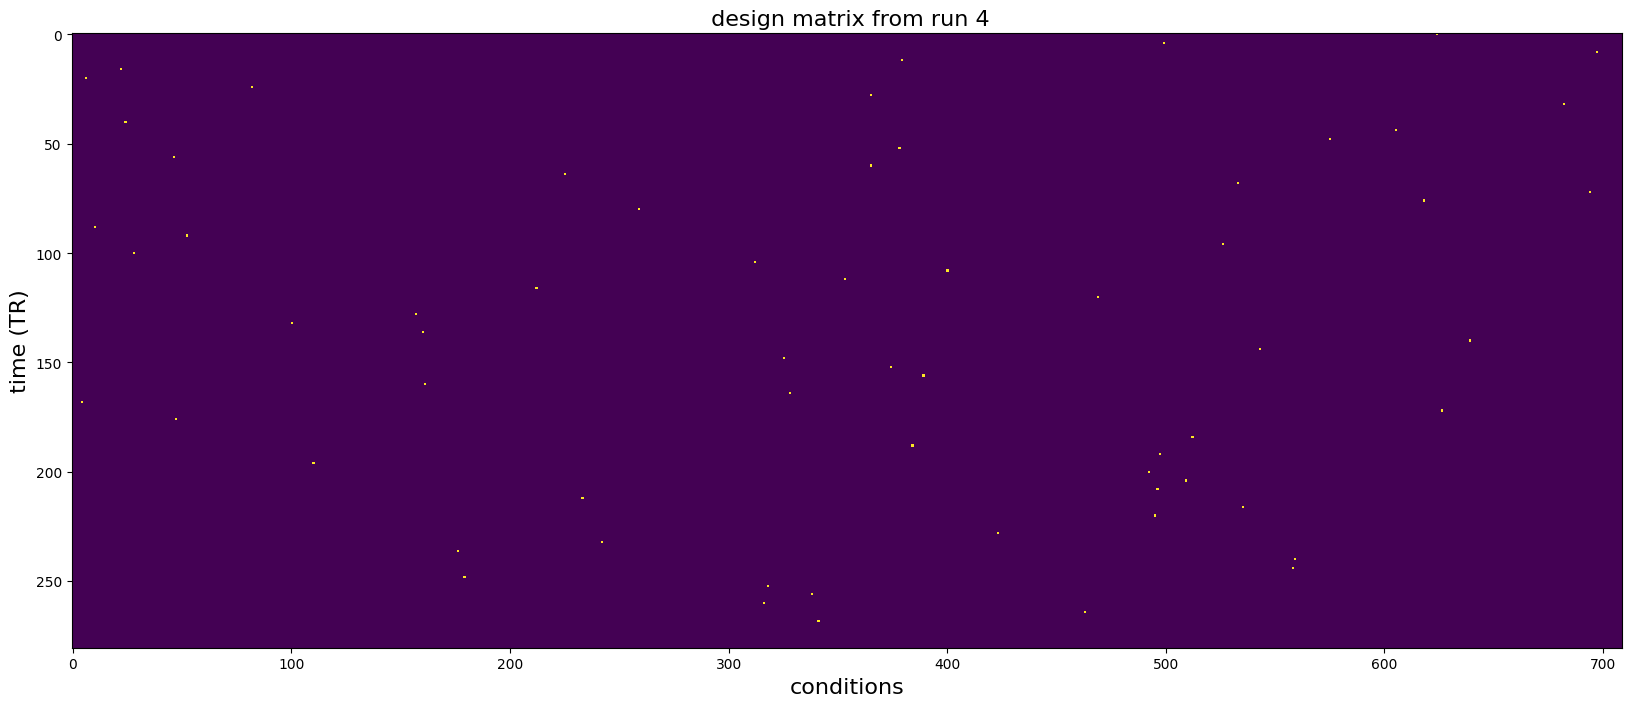

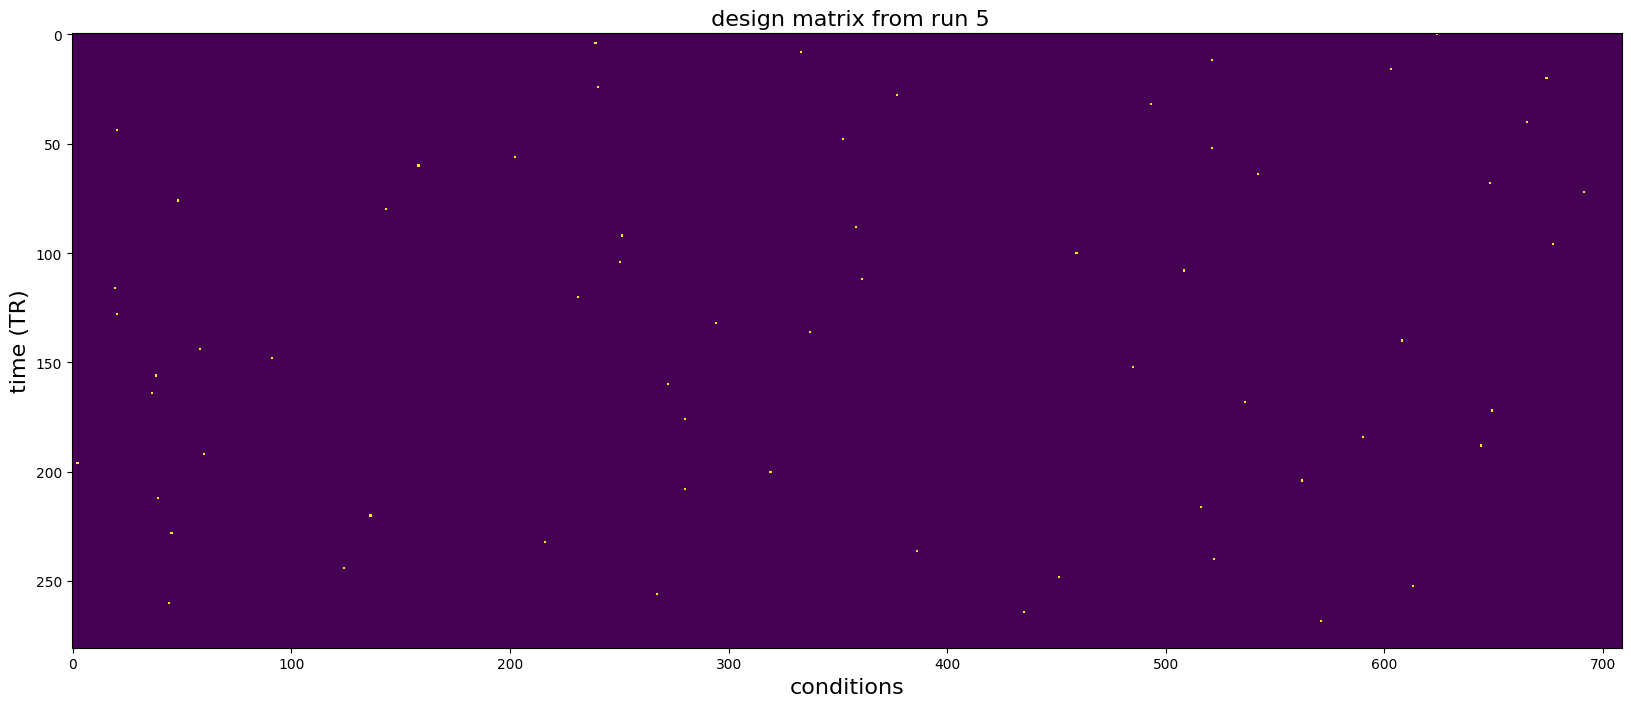

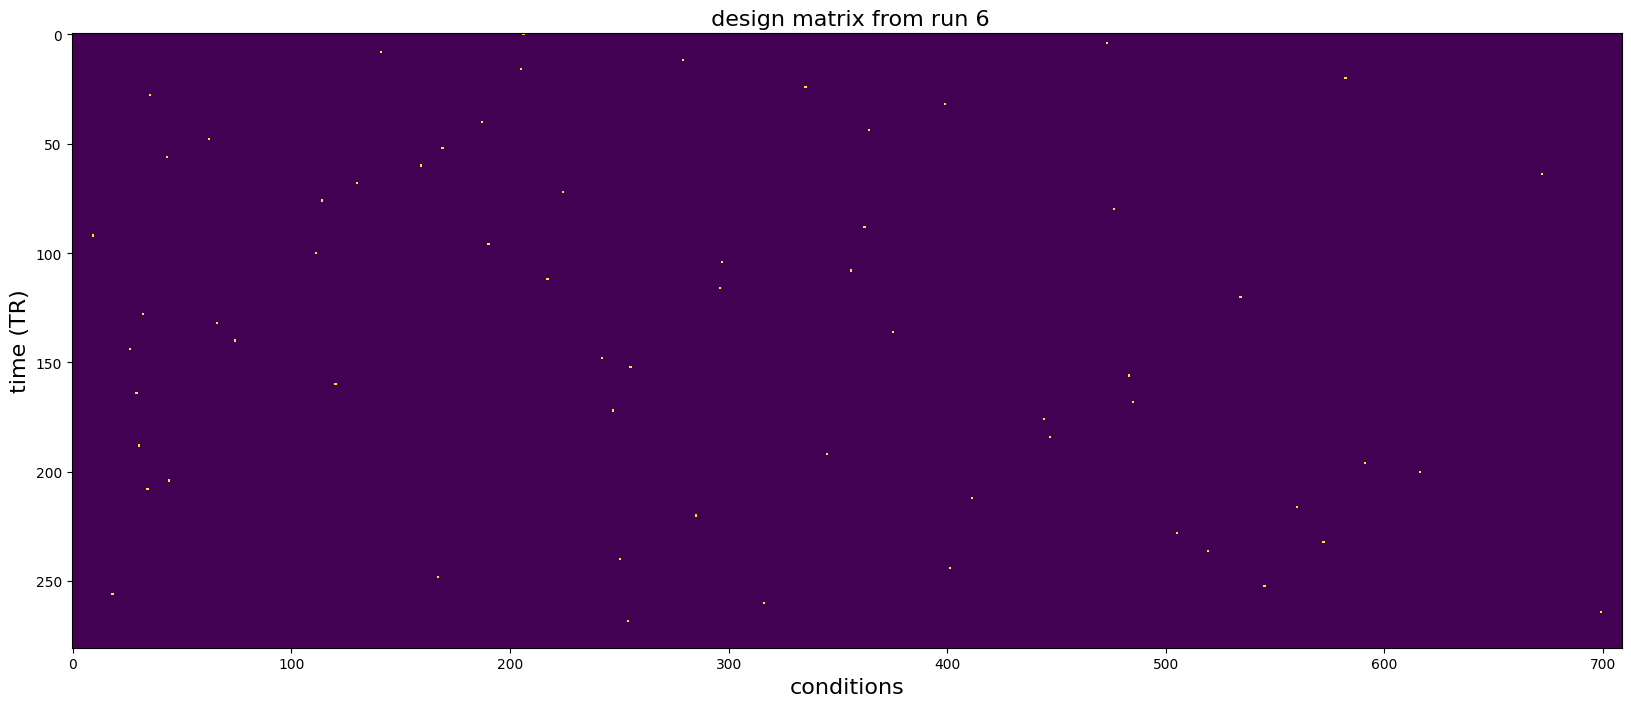

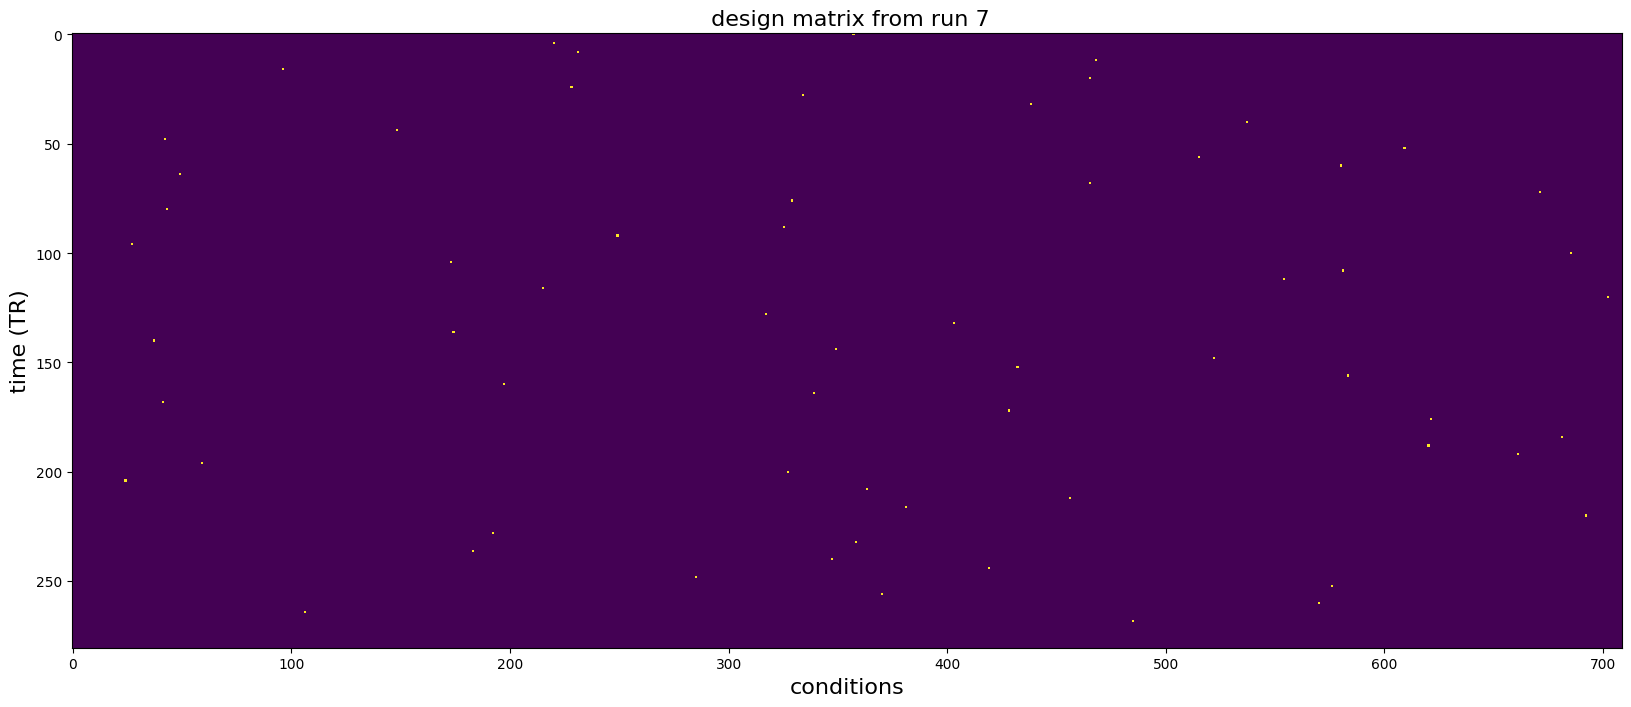

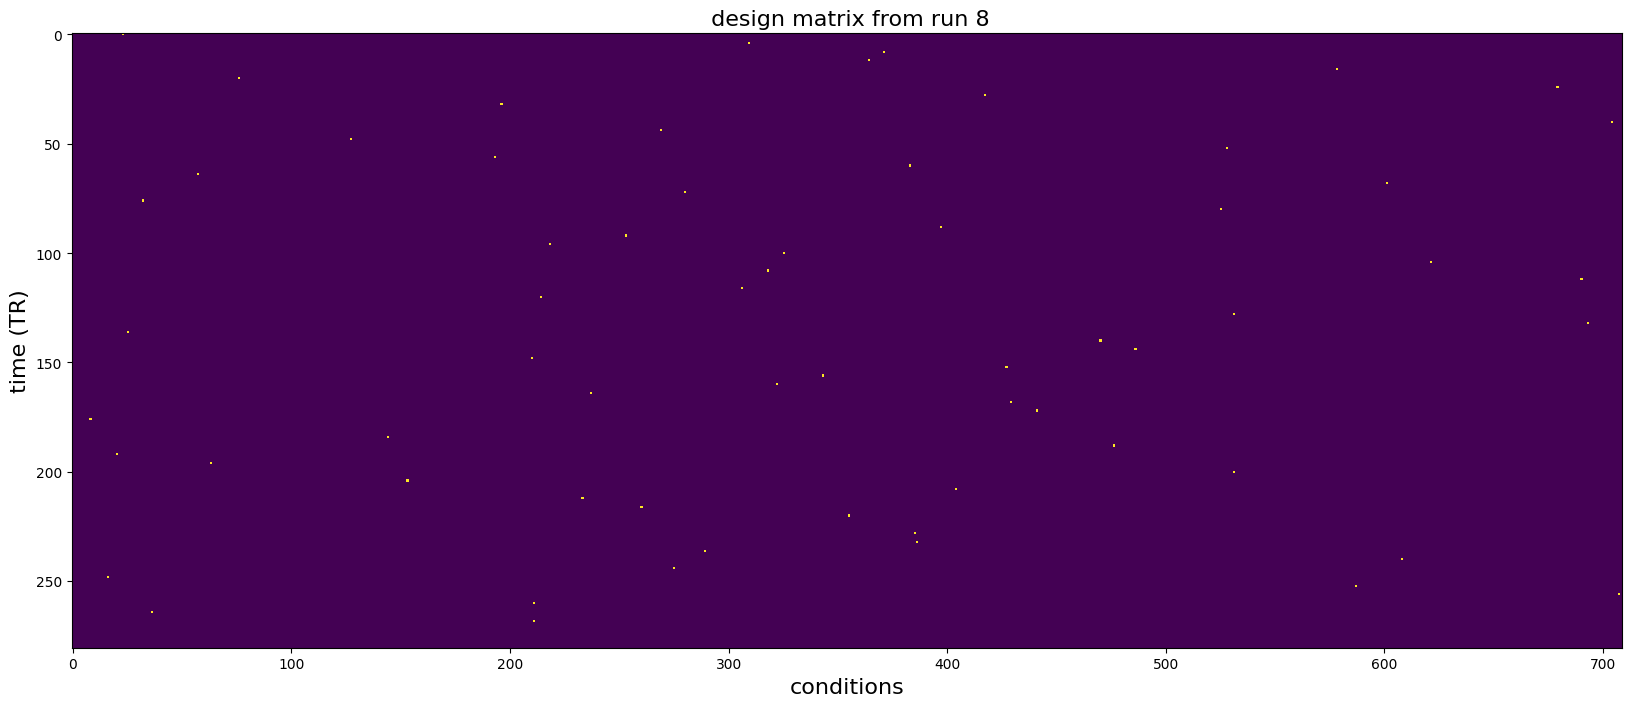

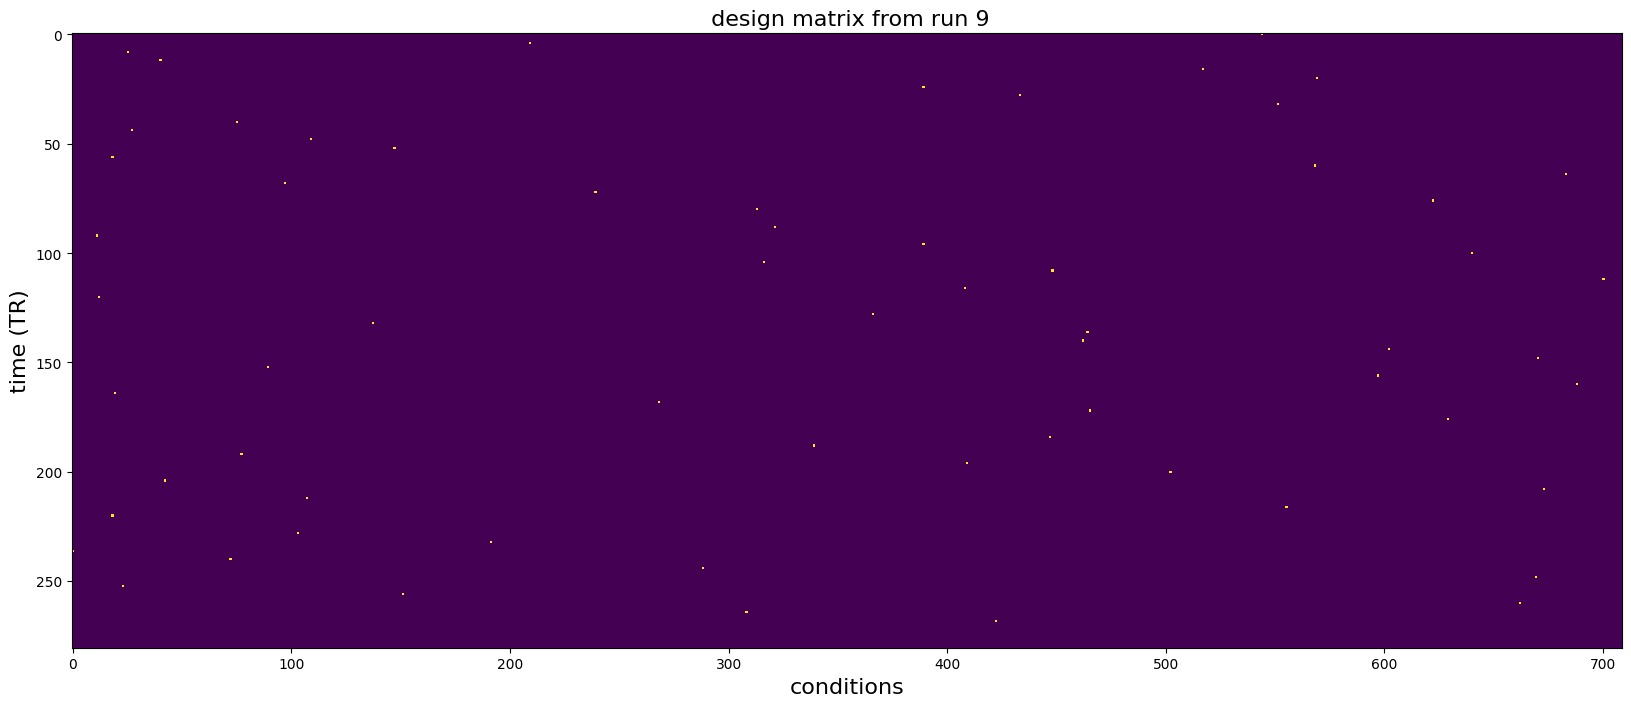

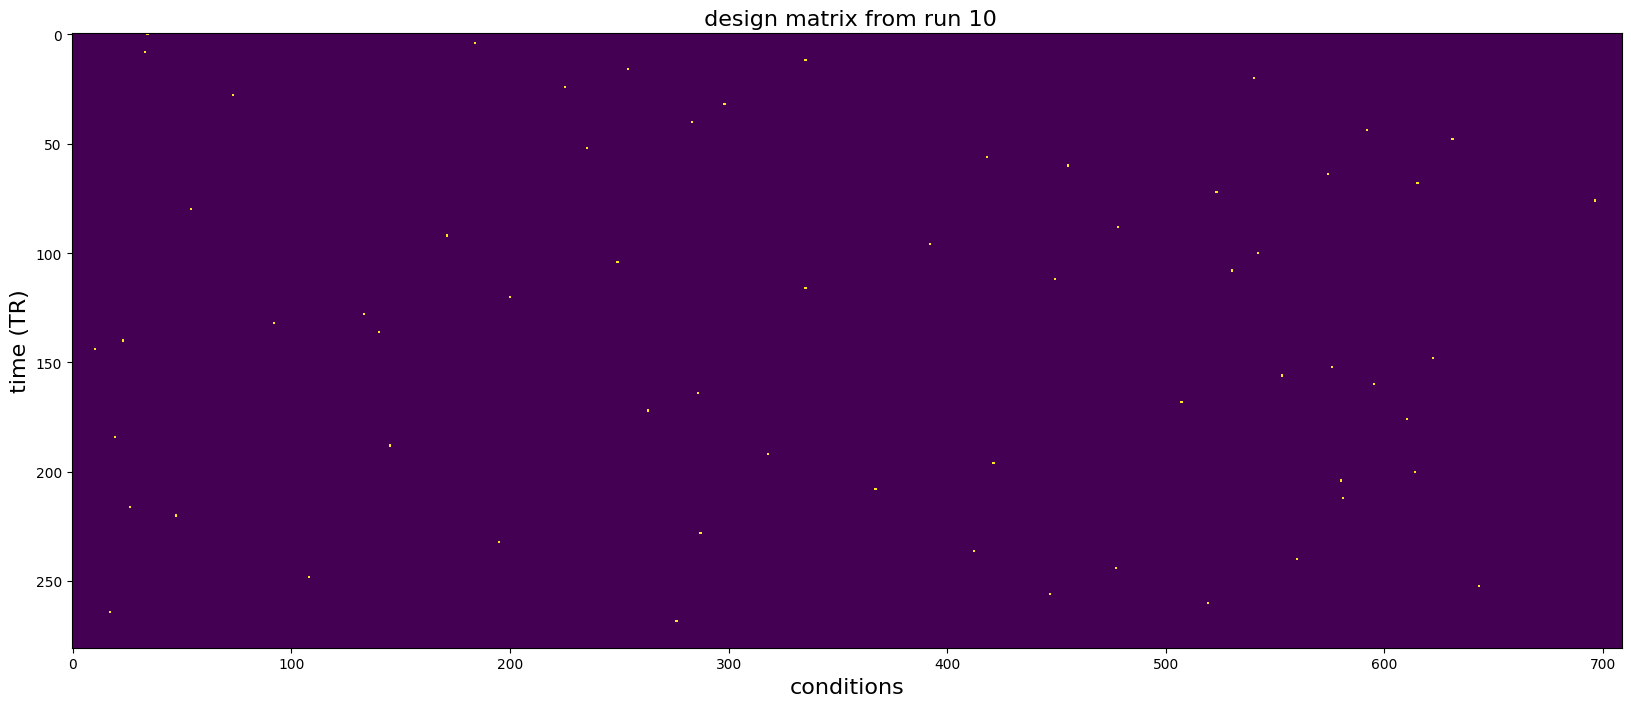

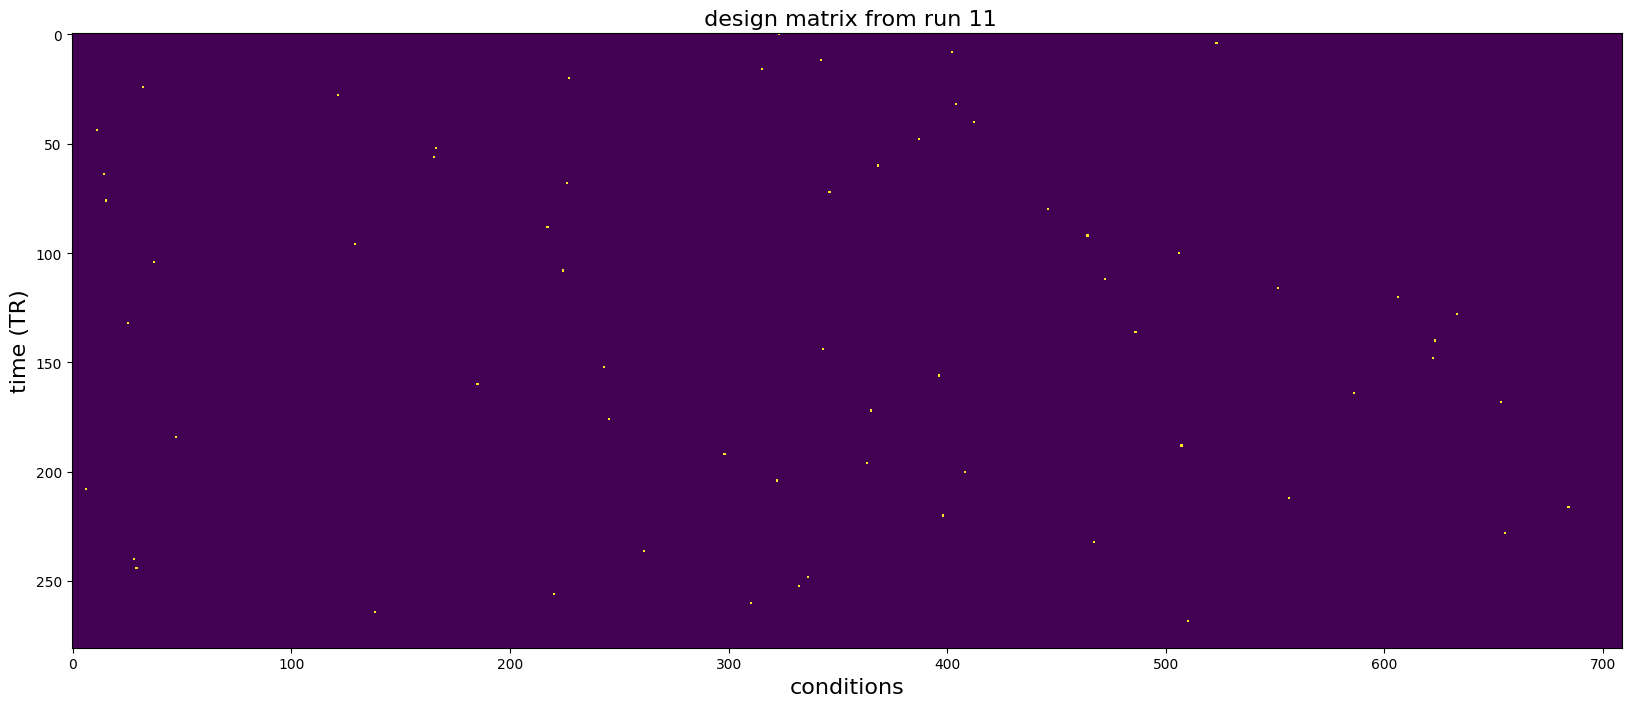

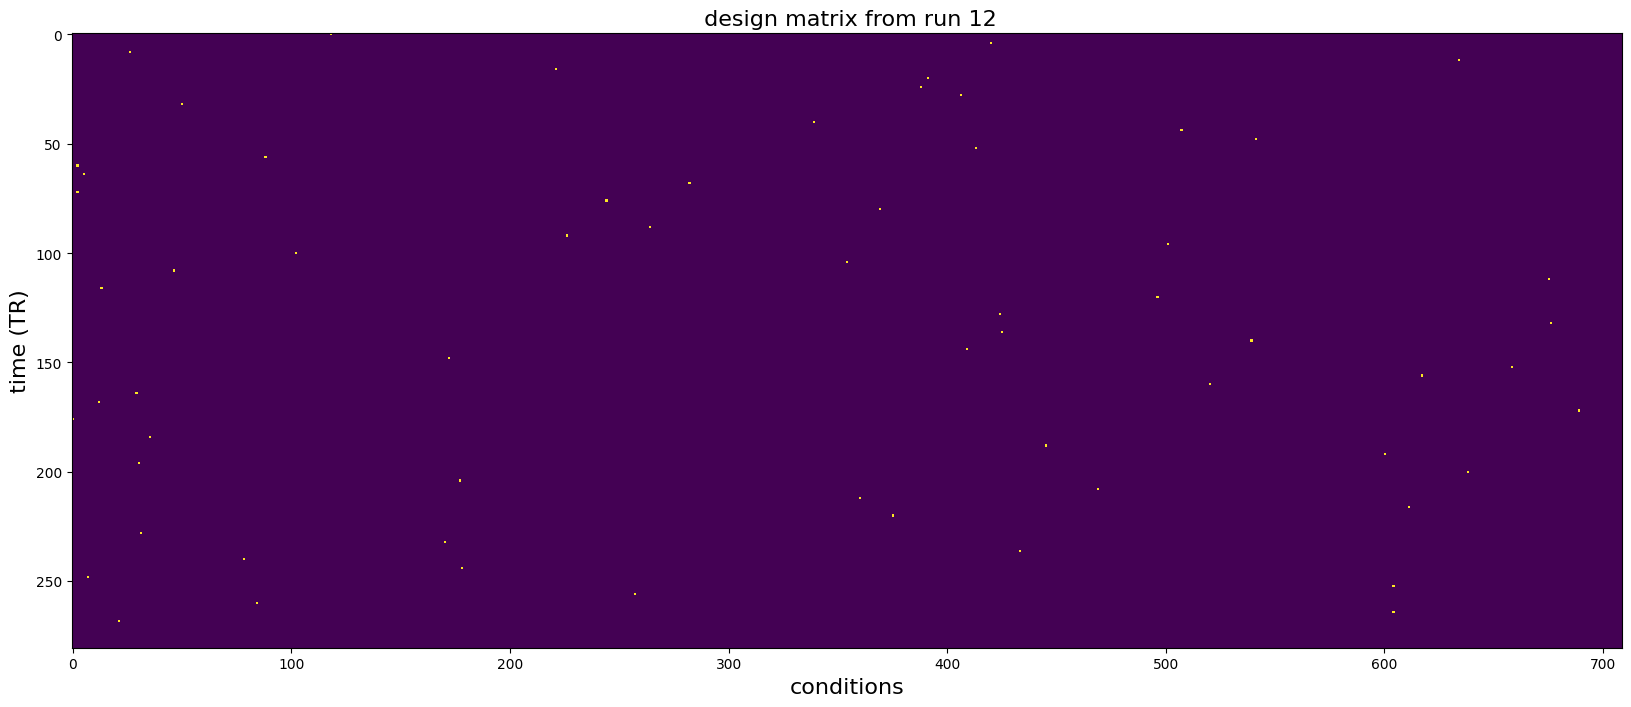

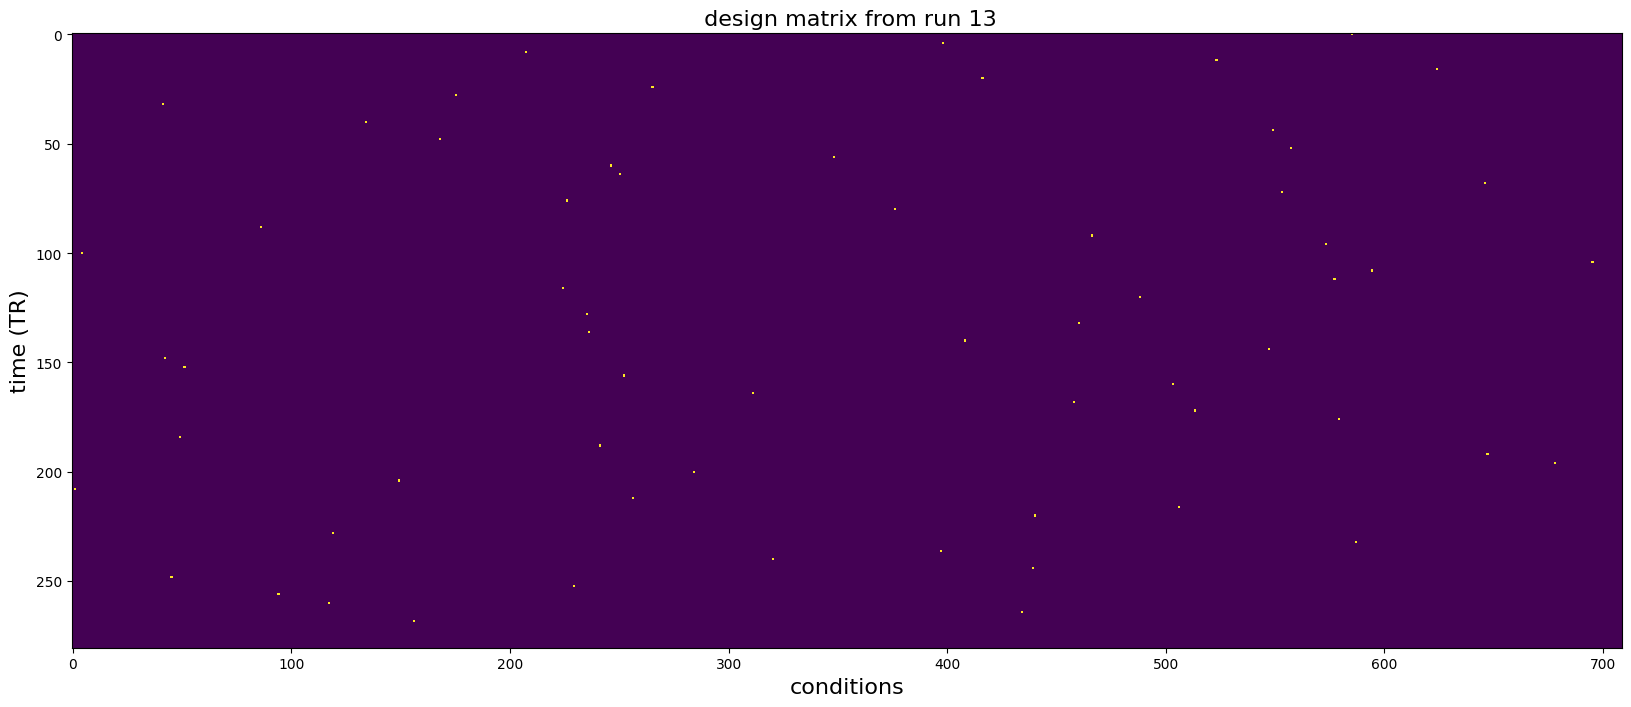

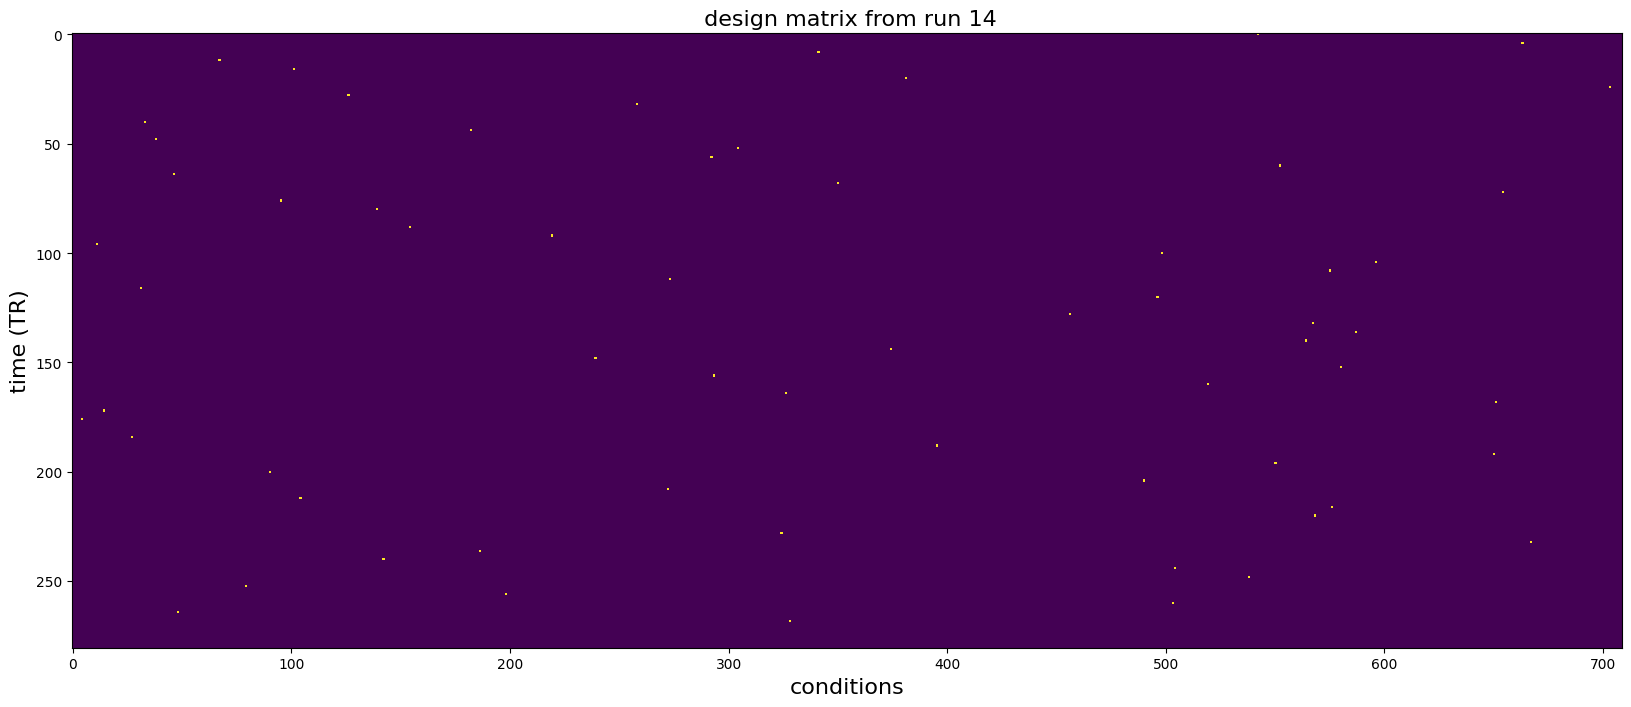

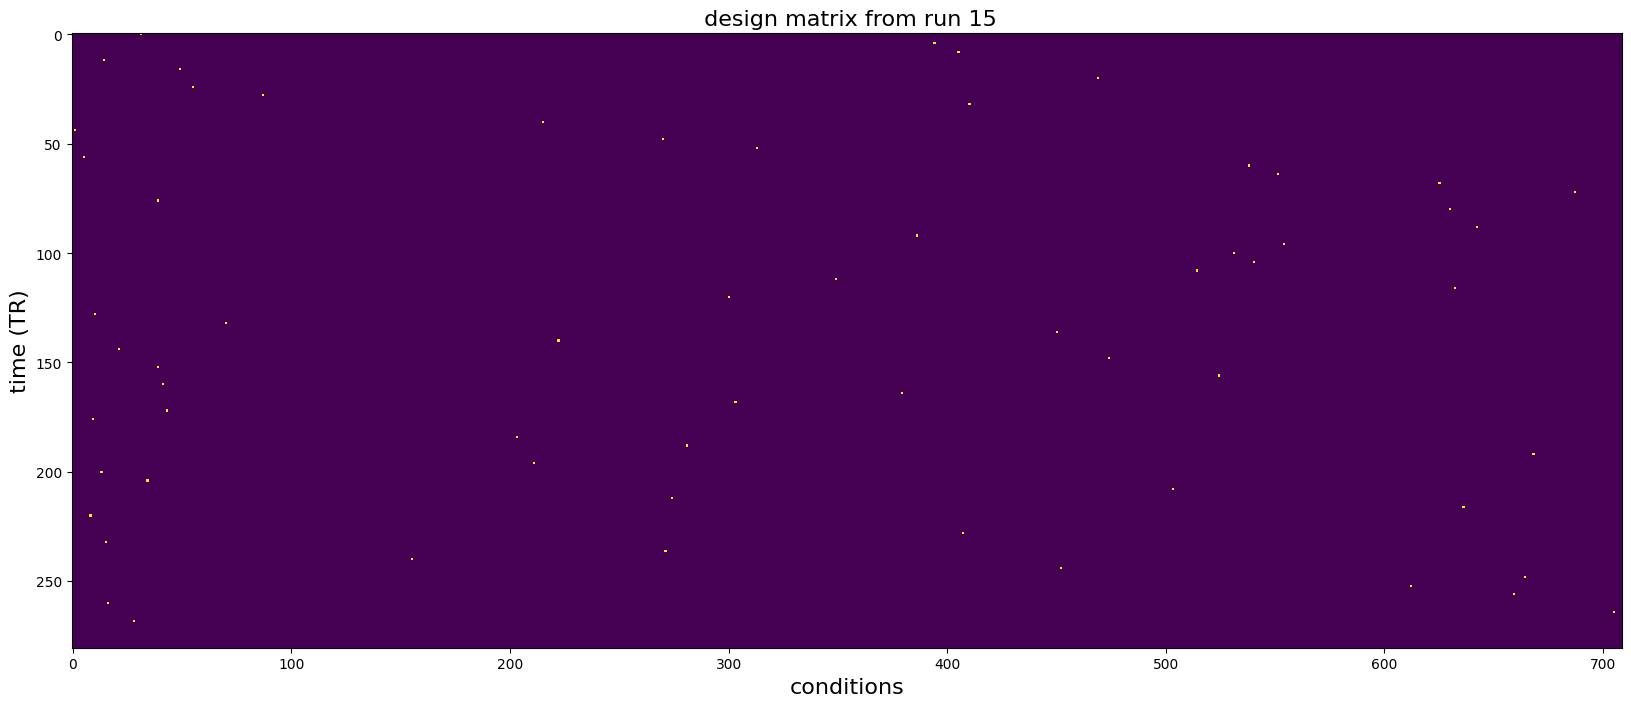

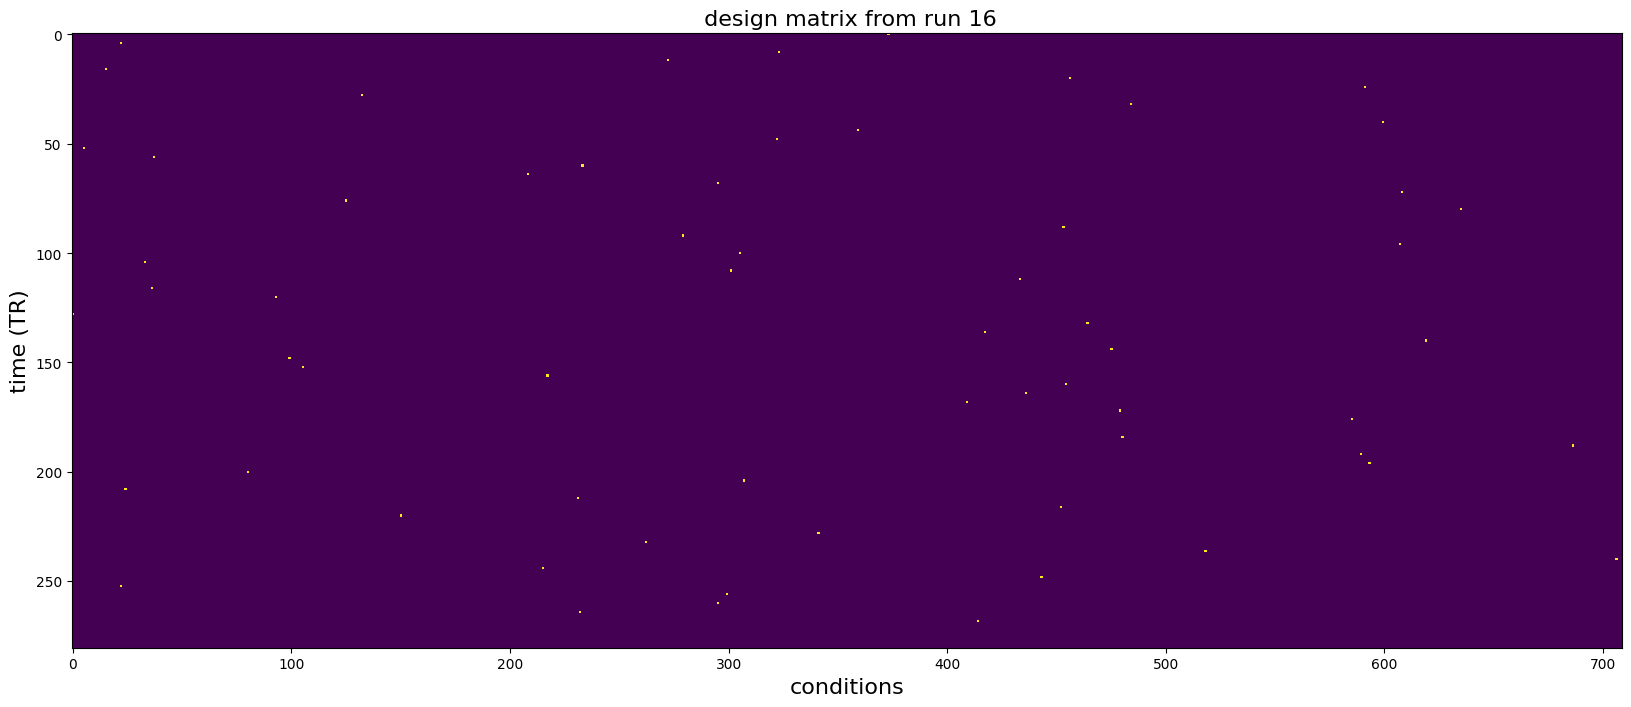

In [29]:
# Plot design matrix for each run
for run in range(n_runs):
    plt.figure(figsize=(20,20))
    plt.imshow(design[run][:,:],interpolation='none')
    plt.title(' design matrix from run %i' %(run+1), fontsize=16)
    plt.xlabel('conditions',fontsize=16)
    plt.ylabel('time (TR)',fontsize=16) 

## Run GLMsingle with default parameters to estimate single-trial betas

In [62]:
# outputs and figures will be stored in a folder (you can specify its name
# as the 5th output to GLMsingle). model estimates can be also
# saved to the 'results' variable which is the only output of
# GLMsingle.

# optional parameters below can be assigned to a structure, i.e., opt =
# dict('wantlibrary':1, 'wantglmdenoise':1); options are the 6th input to
# GLMsingle.

# there are many options that can be specified; here, we comment on the
# main options that one might want to modify/set. defaults for the options
# are indicated below.

# wantlibrary = 1 -> fit HRF to each voxel 
# wantglmdenoise = 1 -> use GLMdenoise 
# wantfracridge = 1 -> use ridge regression to improve beta estimates 
# chunklen = 50000 -> is the number of voxels that we will
#    process at the same time. for setups with lower memory, you may need to 
#    decrease this number.

# wantmemoryoutputs is a logical vector [A B C D] indicating which of the
#     four model types to return in the output <results>. the user must be
#     careful with this, as large datasets can require a lot of RAM. if you
#     do not request the various model types, they will be cleared from
#     memory (but still potentially saved to disk). default: [0 0 0 1]
#     which means return only the final type-D model.

# wantfileoutputs is a logical vector [A B C D] indicating which of the
#     four model types to save to disk (assuming that they are computed). A
#     = 0/1 for saving the results of the ONOFF model, B = 0/1 for saving
#     the results of the FITHRF model, C = 0/1 for saving the results of the
#     FITHRF_GLMdenoise model, D = 0/1 for saving the results of the
#     FITHRF_GLMdenoise_RR model. default: [1 1 1 1] which means save all
#     computed results to disk.

# numpcstotry (optional) is a non-negative integer indicating the maximum
#     number of GLMdenoise PCs to enter into the model. default: 10.

# fracs (optional) is a vector of fractions that are greater than 0
#     and less than or equal to 1. we automatically sort in descending
#     order and ensure the fractions are unique. these fractions indicate
#     the regularization levels to evaluate using fractional ridge
#     regression (fracridge) and cross-validation. default:
#     fliplr(.05:.05:1). a special case is when <fracs> is specified as a
#     single scalar value. in this case, cross-validation is NOT performed
#     for the type-D model, and we instead blindly use the supplied
#     fractional value for the type-D model.

In [30]:
# create a directory for saving GLMsingle outputs
#outputdir_glmsingle = join(homedir,'examples','example1outputs','GLMsingle')
outputdir_glmsingle = join(homedir,'derivatives','glmsingle', sub, f'glmsingle_{session}')
figuredir_glmsingle = join(homedir,'derivatives','glmsingle', 'figures', sub)
os.makedirs(outputdir_glmsingle,exist_ok=True)
os.makedirs(figuredir_glmsingle,exist_ok=True)

opt = dict()

# set important fields for completeness (but these would be enabled by default)
opt['wantlibrary'] = 1
opt['wantglmdenoise'] = 1
opt['wantfracridge'] = 1

# for the purpose of this example we will keep the relevant outputs in memory
# and also save them to the disk
opt['wantfileoutputs'] = [0,0,0,1]
opt['wantmemoryoutputs'] = [1,1,1,1]
#opt['wanthdf5'] = 1

# running python GLMsingle involves creating a GLM_single object
# and then running the procedure using the .fit() routine
glmsingle_obj = GLM_single(opt)

# visualize all the hyperparameters
pprint(glmsingle_obj.params)

{'R2thresh': 0,
 'brainR2': [],
 'brainexclude': False,
 'brainthresh': [99.0, 0.1],
 'chunklen': 50000,
 'extra_regressors': False,
 'fracs': array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
       0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05]),
 'hrffitmask': 1,
 'hrfmodel': 'optimise',
 'hrfthresh': 0.5,
 'lambda': 0,
 'n_boots': 100,
 'n_jobs': 1,
 'n_pcs': 10,
 'numforhrf': 50,
 'pcR2cutoff': [],
 'pcR2cutoffmask': 1,
 'pcstop': 1.05,
 'seed': 1727200737.9181695,
 'suppressoutput': 0,
 'wantautoscale': 1,
 'wantfileoutputs': [0, 0, 0, 1],
 'wantfracridge': 1,
 'wantglmdenoise': 1,
 'wanthdf5': 0,
 'wantlibrary': 1,
 'wantlss': 0,
 'wantmemoryoutputs': [1, 1, 1, 1],
 'wantparametric': 0,
 'wantpercentbold': 1}


In [31]:
print('shape of data before running GLMsingle:')
print(data_upsampled[0].shape)
print('shape of design matrix:')
print(design[0].shape)

shape of data before running GLMsingle:
(186947, 281)
shape of design matrix:
(281, 709)


In [ ]:
# Try running with brainexclude=avg_mask
# if it crashes, then increase max to 1,500,000

# this example saves output files to the outputdir folder
# if these outputs don't already exist, we will perform the time-consuming call to GLMsingle;
# otherwise, we will just load from disk.

start_time = time.time()

#if not exists(outputdir_glmsingle):
if run_glmsingle == 1:
    print('saving outputs to', outputdir_glmsingle)
    print(f'running GLMsingle...')
    
    # run GLMsingle
    results_glmsingle = glmsingle_obj.fit(
       design,
       data_upsampled,
       stimdur,
       tr,
       outputdir=outputdir_glmsingle,
       figuredir=figuredir_glmsingle
       )
    
    # save results in memory to npz
    np.savez(join(outputdir_glmsingle,'TYPEA_ONOFF.npz'), **results_glmsingle['typea'])
    np.savez(join(outputdir_glmsingle,'TYPEB_FITHRF.npz'), **results_glmsingle['typeb'])
    np.savez(join(outputdir_glmsingle,'TYPEC_FITHRF_GLMDENOISE.npz'), **results_glmsingle['typec'])
    np.savez(join(outputdir_glmsingle,'TYPED_FITHRF_GLMDENOISE_RR.npz'), **results_glmsingle['typed'])
    
    # we assign outputs of GLMsingle to the "results_glmsingle" variable.
    # note that results_glmsingle['typea'] contains GLM estimates from an ONOFF model,
    # where all images are treated as the same condition. these estimates
    # could be potentially used to find cortical areas that respond to
    # visual stimuli. we want to compare beta weights between conditions
    # therefore we are not going to include the ONOFF betas in any analyses of 
    # voxel reliability
    
elif run_glmsingle == 0:
    print(f'loading existing GLMsingle outputs from directory:\n\t{outputdir_glmsingle}')
    # takes about 2 minutes to load
    
    # load existing file outputs if they exist
    results_glmsingle = dict()
    
    if opt['wanthdf5'] == 1: #if outputs are in hdf5 format
        results_intm = dict()
        results_intm['typea'] = h5py.File(join(outputdir_glmsingle,'TYPEA_ONOFF.hdf5'), 'r')
        results_intm['typeb'] = h5py.File(join(outputdir_glmsingle,'TYPEB_FITHRF.hdf5'), 'r')
        results_intm['typec'] = h5py.File(join(outputdir_glmsingle,'TYPEC_FITHRF_GLMDENOISE.hdf5'), 'r')
        results_intm['typed'] = h5py.File(join(outputdir_glmsingle,'TYPED_FITHRF_GLMDENOISE_RR.hdf5'), 'r')
        
        model_types = ['typea', 'typeb', 'typec', 'typed']
        for model in range(len(model_types)):
            results_glmsingle[model_types[model]] = dict()
            plot_fields = list(results_intm[model_types[model]].keys())
    
            for i in range(len(plot_fields)):
                results_glmsingle[model_types[model]][plot_fields[i]] = results_intm[model_types[model]].get(plot_fields[i]).value
    
    else: #load npy files
        #results_glmsingle['typea'] = np.load(join(outputdir_glmsingle,'TYPEA_ONOFF.npy'),allow_pickle=True).item()
        #results_glmsingle['typeb'] = np.load(join(outputdir_glmsingle,'TYPEB_FITHRF.npy'),allow_pickle=True).item()
        #results_glmsingle['typec'] = np.load(join(outputdir_glmsingle,'TYPEC_FITHRF_GLMDENOISE.npy'),allow_pickle=True).item()
        #results_glmsingle['typed'] = np.load(join(outputdir_glmsingle,'TYPED_FITHRF_GLMDENOISE_RR.npy'),allow_pickle=True).item()
        results_glmsingle['typea'] = np.load(join(outputdir_glmsingle,'TYPEA_ONOFF.npz'))
        results_glmsingle['typeb'] = np.load(join(outputdir_glmsingle,'TYPEB_FITHRF.npz'))
        results_glmsingle['typec'] = np.load(join(outputdir_glmsingle,'TYPEC_FITHRF_GLMDENOISE.npz'))
        results_glmsingle['typed'] = np.load(join(outputdir_glmsingle,'TYPED_FITHRF_GLMDENOISE_RR.npz'))
        
elapsed_time = time.time() - start_time

print(
    '\telapsed time: ',
    f'{time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}'
)

saving outputs to /jukebox/norman/rsiyer/rtmindeye/data_correct/bids/derivatives/glmsingle/sub-001/glmsingle_ses-03
running GLMsingle...
*** DIAGNOSTICS ***:
There are 16 runs.
The number of conditions in this experiment is 709.
The stimulus duration corresponding to each trial is 3.00 seconds.
The TR (time between successive data points) is 1.00 seconds.
The number of trials in each run is: [63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63].
The number of trials for each condition is: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

chunks:  25%|██████████████████▌                                                       | 1/4 [22:09<1:06:29, 1329.97s/it]

## Summary of important outputs

the outputs of GLMsingle are formally documented in its header. here, we highlight a few of the more important outputs:

* R2 -> is model accuracy expressed in terms of R^2 (percentage).

* betasmd -> is the full set of single-trial beta weights (X x Y x Z x TRIALS). beta weights are arranged in chronological order.

* HRFindex -> is the 1-index of the best fit HRF. HRFs can be recovered with getcanonicalHRFlibrary(stimdur,tr)

* FRACvalue -> is the fractional ridge regression regularization level chosen for each voxel. values closer to 1 mean less regularization.

In [ ]:
# GLMsingle output is in 2D format (voxels,samples)
# we need to unmask the data to get it back into 3D/4D format:
# X = nilearn.masking.unmask(results_glmsingle['typeb']['HRFindex'], avg_mask)
# X_hrf = X.get_fdata()

In [ ]:
# results_out = {
#                     'onoffR2': np.reshape(onoffR2, [nx, ny, nz]),
#                     'meanvol': np.reshape(meanvol, [nx, ny, nz]),
#                     'betasmd': np.reshape(betasmd, [nx, ny, nz])
#                     }

In [ ]:
# convert everything back to 3D/4D array format
model_types = ['typea','typeb','typec','typed']

results_glmsingle_3D = dict()

for model in range(len(model_types)):
    results_glmsingle_3D[model_types[model]] = dict()
    
    #plot_fields = list(results_glmsingle[model_types[model]].keys())
    #print(model, plot_fields)
    
    if model == 0: #type A
        plot_fields = ['betasmd','meanvol','onoffR2']
    elif model == 1: #type B
        plot_fields = ['betasmd','meanvol', 'R2','HRFindex', 'FitHRFR2']
    elif model == 2: #type C
        plot_fields = ['betasmd','meanvol', 'R2','HRFindex']
    elif model == 3: #type D
        plot_fields = ['betasmd','meanvol', 'R2','HRFindex','FRACvalue']
    print(model_types[model])
    
    for i in range(len(plot_fields)):
        print(plot_fields[i])
        # find time dimension
        dim = len(results_glmsingle[model_types[model]][plot_fields[i]].shape)-1
        # flatten to 2D
        mflat = reshape2D(results_glmsingle[model_types[model]][plot_fields[i]],dim) 
        print('original shape:', results_glmsingle[model_types[model]][plot_fields[i]].shape)
        print('2D shape:', mflat.shape)
        # unmask_data = nilearn.masking.unmask(results_glmsingle[model_types[model]][plot_fields[i]].T, avg_mask)
        unmask_data = nilearn.masking.unmask(mflat, avg_mask)
        results_glmsingle_3D[model_types[model]][plot_fields[i]] = unmask_data.get_fdata()
        print('shape of unmasked data:', results_glmsingle_3D[model_types[model]][plot_fields[i]].shape)
        print('')

## Plot a slice of brain showing GLMsingle outputs

In [ ]:
# we are going to plot several outputs from the FIT_HRF_GLMdenoise_RR GLM,
# which contains the full set of GLMsingle optimizations.

# choose a slice
#z=round(xyz[2]/3)
z=29

# we will plot betas, R2, optimal HRF indices, and the voxel frac values
plot_fields = ['betasmd','R2','HRFindex','FRACvalue']
#plot_fields = ['betasmd']
colormaps = ['RdBu_r','hot','jet','copper']
clims = [[-5,5],[0,85],[0,20],[0,1]]

plt.figure(figsize=(12,8))

for i in range(len(plot_fields)):
    
    plt.subplot(2,2,i+1)
    
    if i == 0:
        # when plotting betas, for simplicity just average across all image presentations
        # this will yield a summary of whether voxels tend to increase or decrease their 
        # activity in response to the experimental stimuli (similar to outputs from 
        # an ONOFF GLM)
        plot_data = np.nanmean(np.squeeze(results_glmsingle_3D['typed'][plot_fields[i]]),3)
        titlestr = 'average GLM betas (1000 trials)'
    
    else:
        # plot all other voxel-wise metrics as outputted from GLMsingle
        plot_data = np.squeeze(results_glmsingle_3D['typed'][plot_fields[i]].reshape(xyz))
        titlestr = plot_fields[i]
    
    plt.imshow(plot_data[:,:,z],cmap=colormaps[i],clim=clims[i])
    plt.colorbar()
    plt.title(titlestr)
    plt.axis(False)

## Run a baseline GLM to compare with GLMsingle outputs

In [ ]:
# for comparison purposes we are going to run a standard GLM
# without HRF fitting, GLMdenoise, or ridge regression regularization. we
# will compute the split-half reliability at each voxel using this baseline
# GLM, and then assess whether reliability improves using the output betas
# from GLMsingle. 

# output directory for baseline GLM
outputdir_baseline = join(homedir,'derivatives','glmsingle', sub, 'glmbaseline')
os.makedirs(outputdir_baseline,exist_ok=True)

# we will run this baseline GLM by changing the default settings in GLMsingle 
# contained within the "opt" structure.
opt = dict() 

# turn off optimizations 
opt['wantlibrary'] = 0 # switch off HRF fitting
opt['wantglmdenoise'] = 0 # switch off GLMdenoise
opt['wantfracridge'] = 0 # switch off ridge regression

# for the purpose of this example we will keep the relevant outputs in memory
# and also save them to the disk...
# the first two indices are the ON-OFF GLM and the baseline single-trial GLM. 
# no need to save the third (+ GLMdenoise) and fourth (+ fracridge) outputs
# since they will not even be computed

opt['wantmemoryoutputs'] = [1,1,0,0] 
opt['wantfileoutputs'] = [1,1,0,0]
#opt['wanthdf5'] = 1

# running python GLMsingle involves creating a GLM_single object
# and then running the procedure using the .fit() routine
glmbaseline_obj = GLM_single(opt)

# visualize the hyperparameters, including the modified baseline opts
pprint(glmbaseline_obj.params)

In [ ]:
start_time = time.time()

# if these outputs don't already exist, we will perform the call to
# GLMsingle; otherwise, we will just load from disk.
#if not exists(outputdir_baseline):
if run_glmbaseline == 1:
    
    print(f'running GLMsingle...')

    # run GLMsingle, fitting the baseline GLM
    results_assumehrf = glmbaseline_obj.fit(
       design,
       data_upsampled,
       stimdur,
       tr,
       outputdir=outputdir_baseline)
    
    # save results in memory to npz
    np.savez(join(outputdir_baseline,'TYPEA_ONOFF.npz'), **results_assumehrf['typea'])
    np.savez(join(outputdir_baseline,'TYPEB_FITHRF.npz'), **results_assumehrf['typeb'])

elif run_glmbaseline == 0:
    
    print(f'loading existing GLMsingle outputs from directory:\n\t{outputdir_baseline}')
    
    results_assumehrf = dict()
    
    if opt['wanthdf5'] == 1: #if outputs are in hdf5 format
        results_intm2 = dict()
        results_intm2['typea'] = h5py.File(join(outputdir_baseline,'TYPEA_ONOFF.hdf5'), 'r')
        results_intm2['typeb'] = h5py.File(join(outputdir_baseline,'TYPEB_FITHRF.hdf5'), 'r')
        
        model_types = ['typea', 'typeb']
        for model in range(len(model_types)):
            results_assumehrf[model_types[model]] = dict()
            plot_fields = list(results_intm2[model_types[model]].keys())
    
            for i in range(len(plot_fields)):
                results_assumehrf[model_types[model]][plot_fields[i]] = results_intm2[model_types[model]].get(plot_fields[i]).value
    else:
        #results_assumehrf['typea'] = np.load(join(outputdir_baseline,'TYPEA_ONOFF.npy'),allow_pickle=True).item()
        #results_assumehrf['typeb'] = np.load(join(outputdir_baseline,'TYPEB_FITHRF.npy'),allow_pickle=True).item()
        results_assumehrf['typea'] = np.load(join(outputdir_baseline,'TYPEA_ONOFF.npz'))
        results_assumehrf['typeb'] = np.load(join(outputdir_baseline,'TYPEB_FITHRF.npz'))
    
    # note that even though we are loading TYPEB_FITHRF betas, HRF fitting
    # has been turned off and this struct field will thus contain the
    # outputs of a GLM fit using the canonical HRF.
    
elapsed_time = time.time() - start_time
print(
    '\telapsed time: ',
    f'{time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}'
)

In [ ]:
# convert back to 3D/4D array format
model_types = ['typea','typeb']

results_assumehrf_3D = dict()

for model in range(len(model_types)):
    results_assumehrf_3D[model_types[model]] = dict()
    if model == 0: #type A
        plot_fields = ['betasmd','onoffR2']
    elif model == 1: #type B
        plot_fields = ['betasmd','R2','HRFindex']
    print(model_types[model])
    for i in range(len(plot_fields)):
        print(plot_fields[i])
        # find time dimension
        dim = len(results_assumehrf[model_types[model]][plot_fields[i]].shape)-1
        # flatten to 2D
        mflat = reshape2D(results_assumehrf[model_types[model]][plot_fields[i]],dim) 
        print('original shape:', results_assumehrf[model_types[model]][plot_fields[i]].shape)
        print('2D shape:', mflat.shape)
        unmask_data = nilearn.masking.unmask(mflat, avg_mask)
        # unmask_data = nilearn.masking.unmask(results_assumehrf[model_types[model]][plot_fields[i]].T, avg_mask)
        results_assumehrf_3D[model_types[model]][plot_fields[i]] = unmask_data.get_fdata()
        print('shape of unmasked data:', results_assumehrf_3D[model_types[model]][plot_fields[i]].shape)
        print('')

In [ ]:
# create dictionary containing the GLM betas from the four different models we will compare.
# note that the "assume hrf" betas come from the "typeb" field of our baseline GLM
# (with HRF fitting turned off), and that the "fit hrf" betas also come from 
# the "typeb" field of the GLM that ran with all default GLMsingle routines
# enabled

models = dict()
models['assumehrf'] = results_assumehrf_3D['typeb']['betasmd']#.reshape(xyz + (1000,))
models['fithrf'] = results_glmsingle_3D['typeb']['betasmd']
models['fithrf_glmdenoise'] = results_glmsingle_3D['typec']['betasmd']
models['fithrf_glmdenoise_rr'] = results_glmsingle_3D['typed']['betasmd']

## Get indices of repeated conditions to use for reliability calculations

To compare the results of different GLMs we are going to calculate the voxel-wise split-half reliablity for each model. Reliability values reflect a correlation between beta weights for repeated presentations of the same conditions. In short, we are going to check how reliable/reproducible are the single trial responses to repeated conditions estimated with each GLM type.

In the code below, we are attempting to locate the indices in the beta weight GLMsingle outputs modelmd(x,y,z,trials) that correspond to repeated images.

In [ ]:
if run_reliability == 1:
    
    # consolidate design matrices
    designALL = np.concatenate(design,axis=0)
    print('designALL shape (TRs, conditions):', designALL.shape)

    # construct a vector containing 0-indexed condition numbers in chronological order
    corder = []
    for p in range(designALL.shape[0]):
        if np.any(designALL[p]):
            corder.append(np.argwhere(designALL[p])[0,0])

    corder = np.array(corder)
    
    # let's take a look at the first few entries
    print(corder[:3])
    
    # note that [374 496 7] means that the first stimulus trial involved
    # presentation of the 374th condition (zero-indexed), the second stimulus trial 
    # involved presentation of the 496th condition, and so on.

In [ ]:
# in order to compute split-half reliability, we have to do some indexing.
# we want to find images with least two repetitions and then prepare a
# useful matrix of indices that refer to when these occur.

if run_reliability == 1:
    
    repindices = [] # 2 x images containing stimulus trial indices.

    # the first row refers to the first presentation; the second row refers to
    # the second presentation.
    for p in range(designALL.shape[1]): # loop over every condition

        temp = np.argwhere(corder==p)[:,0] # find indices where this condition was shown
        #print(len(temp)) #vio condition should have 11 As, nonvio should have 9 As
        
        # only add repeated conditions to repindices
        if len(temp) >= 2:
            repindices.append([temp[0], temp[1]]) # note that for now we only look at first 2 repetitions

    repindices = np.vstack(np.array(repindices)).T
    print(repindices.shape, '(repetitions, condition)')

In [ ]:
if run_reliability == 1:
    # let's take a look at a few entries
    print(repindices[:,:3])
    
    # notice that the first condition is presented on the 216th zero-indexed 
    # stimulus trial and the 485th stimulus trial, the second condition is presented on the
    # 217th and 620st stimulus trials, and so on.
    
    print(f'there are {repindices.shape[1]} repeated conditions in the experiment')

# now, for each voxel we are going to correlate beta weights describing the
# response to images presented for the first time with beta weights
# describing the response from the repetition of the same image. with 136
# repeated conditions, the correlation for each voxel will reflect the

## Compute median split-half reliabilty within the ROI for each beta version

In [ ]:
# finally, let's compute split-half reliability. we are going to loop
# through our 4 models and calculate split-half reliability for each of them
if run_reliability == 1:
    
    vox_reliabilities = [] # output variable for reliability values

    modelnames = list(models.keys())#[1:]
    print(modelnames)

    # for each beta version...
    for m in range(len(modelnames)):

        print(f'computing reliability for beta version: {modelnames[m]}')
        time.sleep(1)

        # get the repeated-condition GLM betas using our repindices variable
        betas = models[modelnames[m]][:,:,:,repindices] # automatically reshapes to (X x Y x Z x 2 x nConditions)
        # betas = models[modelnames[m]]['betasmd'][:,None,None,:][:,:,:,repindices] # automatically reshapes to (X x Y x Z x 2 x nConditions)
        x,y,z = betas.shape[:3] 

        rels = np.full((x,y,z),np.nan)

        # loop through voxels in the 3D volume...
        for xx in tqdm(range(x)):
            for yy in range(y):
                for zz in range(z):

                    # reliability at a given voxel is pearson correlation between response profiles from first and 
                    # second image presentations (dim = 136 conditions)
                    rels[xx,yy,zz] = np.corrcoef(betas[xx,yy,zz,0],
                                                 betas[xx,yy,zz,1])[1,0]

        vox_reliabilities.append(rels)

In [ ]:
# load mask defining liberal visual cortex ROI
mask = 'nsdgeneral'
roi = []
mask_file=maskdir + '/%s_%s.nii.gz' % (sub,mask)
print(mask_file)
mask_data=nib.load(mask_file)
roi=mask_data.get_fdata()

assert mask_data.header.get_zooms() == epi_dimsize[:3]
assert mask_data.affine.all() == epi_data.affine.all()
print('roi shape:', roi.shape)
print(np.min(roi), np.max(roi))

roi = roi.astype(float)
# convert voxels outside ROI to nan for overlay plotting
roi[roi==0] = np.nan 
print(np.nanmin(roi), np.nanmax(roi))
print(roi.shape)

roi = roi.flatten()
brain_mask = avg_mask.get_fdata().flatten()
roi = roi[brain_mask.astype(bool)]
roi[np.isnan(roi)] = 0
roi = roi.astype(bool)
print(roi.shape)

In [ ]:
# Save voxel reliabilities in NSDgeneral ROI
if run_reliability == 1:
    vox_rel_nsdgeneral = []
    for vr in vox_reliabilities:
        vox_rel_nsdgeneral.append(vr[avg_mask.get_fdata()==1][roi==True])
        
    savedir=f'/jukebox/norman/rsiyer/rtmindeye/data/bids/derivatives/glmsingle/{sub}/'
    np.save(join(savedir,'voxel_reliabilities_NSDgeneral.npy'), vox_rel_nsdgeneral)

## Assess change in reliability yielded by GLMsingle

In [ ]:
# for each GLM we will calculate median reliability for voxels within the
# nsdgeneral visual ROI and compare using a bar graph
if run_reliability == 1:
    comparison = []
    for vr in vox_reliabilities:
        # comparison.append(np.nanmedian(vr)) 
        comparison.append(np.nanmedian(vr[avg_mask.get_fdata()==1][roi==True]))

    plt.figure(figsize=(18,6))
    plt.subplot(121)
    plt.bar(np.arange(len(comparison)),comparison,width=0.5)
    plt.title('Median voxel split-half reliability of GLM models')
    plt.xticks(np.arange(4),np.array(['ASSUMEHRF','FITHRF', 'FITHRF\nGLMDENOISE', 'FITHRF\nGLMDENOISE\nRR']))
    #plt.ylim([0.1,0.2])

In [ ]:
if run_reliability == 1:
    datasets = ['v1'] #glmsingle versions
    
    info = dict()
    info['v1'] = dict()
    info['v1']['subjs'] = ['sub-001']
    info['methods'] = ['assumehrf', 'fithrf', 'fithrf_glmdenoise', 'fithrf_glmdenoise_rr']

In [ ]:
if run_reliability == 1:
    
    reliability = dict()
    
    #masks = np.load('masks.npy',allow_pickle=True).item() 
    
    # check to be sure all the datafiles exist
    for ds in datasets:
        
        reliability[ds] = dict()
        
        for subj in info[ds]['subjs']:
            
            subj_version_list = []
            
            reliability[ds][subj] = dict()
    
            # load this versions's data
            if ds == 'v1':    
                temp = np.load(join(loaddir,'voxel_reliabilities_NSDgeneral.npy')) 
                method_list = ['assumehrf', 'fithrf', 'fithrf_glmdenoise', 'fithrf_glmdenoise_rr']
            
            for method in method_list:
                if method == 'assumehrf':
                    idx=0
                elif method == 'fithrf':
                    idx=1
                elif method == 'fithrf_glmdenoise':
                    idx=2
                elif method == 'fithrf_glmdenoise_rr':
                    if ds == 'v3':
                        idx=2
                    else:
                        idx=3
    
                rel = temp[idx]
                #rel = np.load(metric_savefn)
                        
                #mask = masks[ds][subj]==1
                
                #if np.ndim(rel) == 3:
                    #rel = rel[mask==1]
                    
                print(ds,method,subj,rel.shape)
                
                reliability[ds][subj][method] = rel
                
                subj_version_list.append(rel)
                           
            reliability[ds][subj]['mean'] = np.mean(np.stack(subj_version_list,axis=1),axis=1)

In [ ]:
if run_reliability == 1:
    
    draw_plots = True
    
    if draw_plots: 
        
        x_version = 'assumehrf'
        y_version = 'fithrf_glmdenoise_rr'
    
        # iterate through datasets
        for ds in datasets:
            for subj in info[ds]['subjs']:
    
                #x = helpers.reshape_nsdgeneral_to_volume(reliability[ds][subj][x_version], masks[ds][subj])
                #y = helpers.reshape_nsdgeneral_to_volume(reliability[ds][subj][y_version], masks[ds][subj])
                x = reliability[ds][subj][x_version]
                y = reliability[ds][subj][y_version]
    
                #x[masks[ds][subj] < 1] = np.nan
                #y[masks[ds][subj] < 1] = np.nan
    
                plt.figure(figsize=(8,8))
                plt.grid('on')
                plt.scatter(x, y, 10, alpha = 0.5)
                plt.axis('square')
    
                plt.plot(np.arange(-0.6,0.7,0.01),np.arange(-0.6,0.7,0.01),'r',linewidth=2.5,zorder=10)
    
                if ds == 'mindeye':
                    ticks = (-0.3,0.8,0.4)
                else:
                    ticks = (-0.3,1,0.4)
    
    plt.xticks(np.round(np.arange(ticks[0],ticks[1],ticks[2]),2),
               np.round(np.arange(ticks[0],ticks[1],ticks[2]),2),fontsize=20)
    plt.yticks(np.round(np.arange(ticks[0],ticks[1],ticks[2]),2),
               np.round(np.arange(ticks[0],ticks[1],ticks[2]),2),fontsize=20)
    
    plt.xlabel(f"{x_version} split-half reliabilities")
    plt.ylabel(f"{y_version} split-half reliabilities")
    plt.title('Beta Version Comparison')
    
    plt.text(0.5, -0.2, x_version, color='blue', fontsize='xx-large')
    plt.text(-0.4, 0.7, y_version, color='red', fontsize='xx-large')
    
    if ds == 'mindeye':
        plt.xlim([-0.5,0.75])
        plt.ylim([-0.5,0.75])
    else:
        plt.xlim([-0.5,1])
        plt.ylim([-0.5,1])
    
    # get rid of the frame
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    
    plt.tight_layout()
    plt.show()

In [ ]:
if run_reliability == 1:
    
    ft = 16
    
    versions = ['assumehrf','fithrf','fithrf_glmdenoise','fithrf_glmdenoise_rr']
    colors = ['dodgerblue','orange','limegreen','tomato']
    
    bins  = np.round(np.arange(-0.2,0.6,0.025),3)
    
    method = 'mean'
    min_nvox = 100
    
    allsubj_diffs = dict()
    
    # iterate through datasets
    for ds in ['v1']:
        
        allsubj_diffs[ds] = dict()
        
        for version in versions:
            allsubj_diffs[ds][version] = []
    
        # iterate through subjects
        for subj in info[ds]['subjs']:
                    
            plt.figure(figsize=(8,8))
            
            subj_mean_metric = reliability[ds][subj]['mean']
            
            subj_version_diffs = []
            
            # iterate through versions
            v=0
            for version in versions:
                
                this_version = reliability[ds][subj][version]
                this_version_diffs = []
                this_version_stds = []
                for val in bins:
               
                    validvox = subj_mean_metric > val
                    
                    if np.sum(validvox) > min_nvox:
                        if method == 'mean':
                            this_version_diffs.append(np.nanmean(this_version[validvox] - subj_mean_metric[validvox]))
                        elif method == 'median':
                            this_version_diffs.append(np.nanmedian(this_version[validvox] - subj_mean_metric[validvox]))
                        this_version_stds.append(np.nanstd(this_version[validvox] - subj_mean_metric[validvox]))
                    else:
                        this_version_diffs.append(np.nan)
                        this_version_stds.append(np.nan)
                        
                
                subj_version_diffs.append(this_version_diffs)
                plt.plot(this_version_diffs,linewidth=12.5,color = colors[v],alpha=1)
                
                v+=1
                
                allsubj_diffs[ds][version].append(this_version_diffs)
            
            plt.plot(np.zeros((len(bins),)),'k--',linewidth=5)
            plt.xticks(np.arange(len(bins))[::8],np.array(bins[::8]),fontsize=ft);
            
            plt.yticks(np.round(np.arange(-0.2,0.3,0.1),2),np.round(np.arange(-0.2,0.3,0.1),2),fontsize=33)
            plt.ylim([-0.22,0.22])
          
            plt.xticks(fontsize=24)
            plt.yticks(fontsize=24)
            plt.xlabel('voxel reliability inclusion threshold')
            plt.ylabel('mean difference in reliability')
            plt.title('Composite Voxel Reliability Scores')
            
            plt.grid('on')        
            plt.legend(versions)
            # get rid of the frame
            for spine in plt.gca().spines.values():
                spine.set_visible(False)
            plt.tight_layout()
            plt.show()